<hr style="border: 1px solid black; width: 100%; margin-left: 0">


<div style="text-align:right"> <b>University of Padua - Department of Physics and Astronomy<b> </div> 
<div style="text-align:right"> <strong> Degree course: </strong> Physics of Data</div>
<div style="text-align:right"><strong>Course: </strong>Information Theory and Inference<b> </div>
<div style="text-align:right"><strong>Year: </strong>2023-2024<b> </div>
<div style="text-align:right"><strong>Teacher in charge: </strong>Michele Allegra<b> </div>
    

#### Students:
- Bonato Diego    - 2091250 - diego.bonato@studenti.unipd.it
- Cacciola Martina - 2097476 - martina.cacciola@studenti.unipd.it
- Merlin Giovanni - 2091186 - giovanni.merlin@studenti.unipd.it

    
<strong>Exam Date</strong>: 19th April 2024
    
<center>
    
# Approximate Bayes Computation: application on the SIR model
<center>
<hr style="border: 1px solid black; width: 100%; margin-left: 0">   

In [9]:
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
import statsmodels.tsa.stattools as st
import seaborn as sns
import scipy.stats as s
from PIL import Image

## The ABC model
In statistical inference, there exist cases in which the likelihood $\mathcal{l}(\theta|y)$ may be unavailable, either because of mathematical or computational reasons. Let us assume we can still simulate the model. In such a setting, we can bypass the computation of the likelihood, using a rejection technique called **Approximate Bayes Computation** (ABC). Starting from the prior distribution, it generates parameters, which are used to sample the data points. To evaluate the goodness of these points, they are compared to the observations using a distance measure. The approximate posterior distribution of the parameters ($\theta$) and latent variables ($z$) given the observed data ($y$) is given by:
$$
\begin{equation}
    \pi_{\epsilon}(\theta, z|y) = \frac{\pi(\theta)f(z|y)\mathbb{I}_{A_{\epsilon,y}}(z)}{\int_{A_{\epsilon,y}\times B} \pi(\theta)f(z|y)dzd\theta}
\end{equation}
$$
where $\mathbb{I}_B(\cdot)$ denotes the indicator function of the set $B$ and $A_{\epsilon,y} = \left\lbrace z \in D | \rho(n(z), n(y)) \leq \epsilon  \right\rbrace$.

ABC simulates data from the model and accepts simulations that are “close enough” to the observed data. The “closeness” is determined by the threshold ($\epsilon$), and the summary statistics function, which serves as a compressed representation of the data. Hence, the intuition behind the algorithm is using a representative summary statistics $\eta$ together with a small tolerance $\epsilon$ should produce a good approximation to the posterior distribution.

## The SIR model

We apply the ABC method to the **SIR model**, a mathematical tool to model the spreading of infectuous diseases. It is a stochastic model, including three possible states for a population:
- _susceptible_ (S): individuals who have not suffered of the disease yet;
- _infected_ (I): individuals who are currently suffering of the disease; 
- _recovered_ (R): individuals who have recovered o have died from the disease. 

The flow of people from S to I, then from I to R is described by a set of differential equations:
$$
\begin{align*}
\frac{dS(t)}{dt} &= -\beta S(t)P(t) \\
\frac{dI(t)}{dt} &= \beta S(t)P(t) - \gamma I (t) \\
\frac{dR (t)}{dt} &= \gamma I (t)
\end{align*}
$$
where $P(t)=I(t)/N$ is the proportion of infectuos individuals at time $t$, $\beta$ is the transmission rate parameter and $\gamma$ the removal rate parameter. The sum of $S(t)$, $I(t)$ and $R(t)$ gives at any moment the total population $N$. The goal of our work is to infer the parameters $\beta$ and $\gamma$.

Let $\Delta I = (\Delta I_1,...,\Delta I_\text{T})^T $ and $\Delta R = (\Delta R_1,...,\Delta R_\text{T})^T $  be sequences of daily reported numbers of newly infected (confirmed) cases and removed cases respectively. Given the initial state of the population $(S_0,I_0,R_0)$, we write the discrete-time stochastic SIR model as follows:
$$
\begin{equation*}
\begin{cases}
\Delta I_t \sim \text{Binomial}\left(S_{t-1}, 1 - \exp(-\beta_t P_{t-1})\right) \\
\Delta R_t \sim \text{Binomial}\left(I_{t-1}, \gamma_t\right) \\
S_t = S_{t-1} - \Delta I_t \\
I_t = I_{t-1} + \Delta I_t - \Delta R_t \\
R_t = R_{t-1} + \Delta R_t
\end{cases}
\end{equation*}
$$


## Target timeseries generation

Firstly, we have generated the target timeseries for the SIR model, i.e. we have specified the values of the parameters $\beta$ and $\gamma$, which are

$$ \beta = 0.1 $$
$$ \gamma = 0.01 $$

The parameter values were chosen to be in line with typical values found in the literature.\
Being it a stochastic model, the shape of the distribution is not fixed, rather it will have an "intrinsic" noise which will impact on the acceptance rate of the samples. However, usually this appears to be of small magnitude.

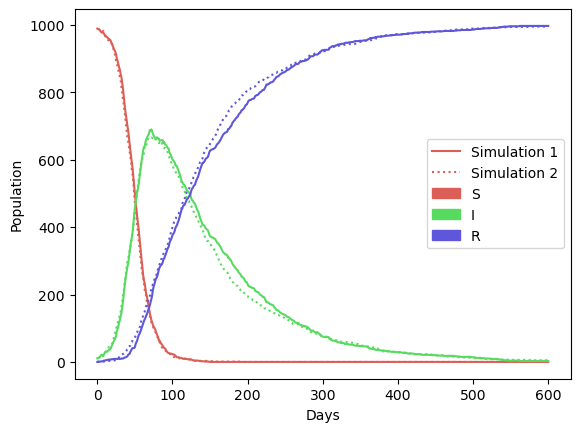

In [ ]:
Image.open('./target_timeseries/target_timeseries.png')

The shape of the priors is the same as considered in [Gu]:

$$ \beta \sim Exp(\lambda=0.1)$$
$$\gamma \sim Beta(\alpha=0.01, \beta=1)$$

In particular the mean of the distributions is equal to the true value of the parameter to be inferred.

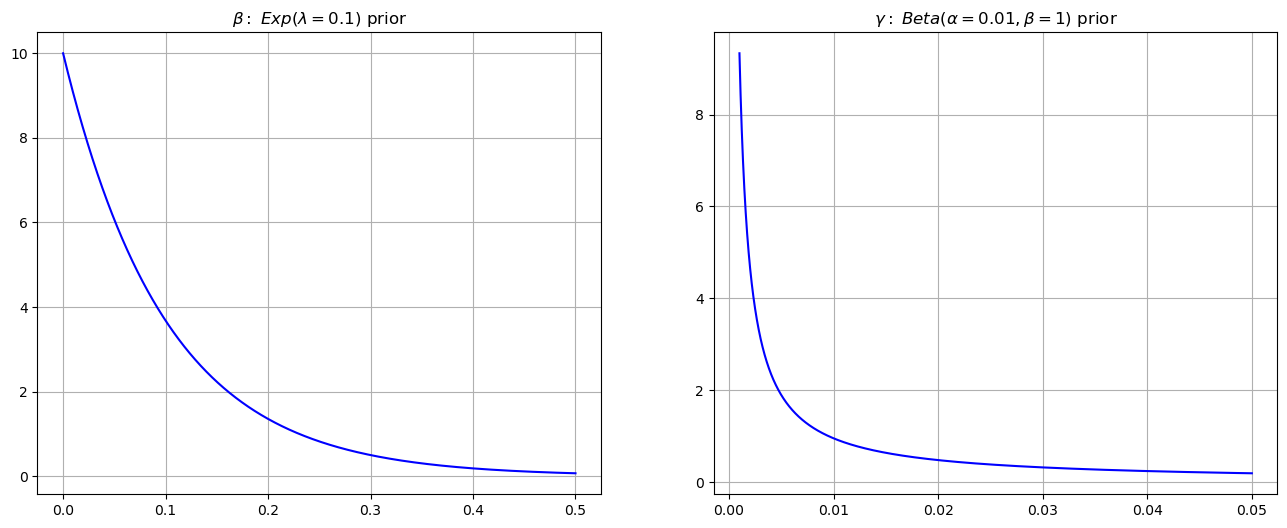

In [ ]:
x_exp = np.linspace(0, 0.5, 10000)
x_beta = np.linspace(0.001, 0.05, 10000)

beta = s.expon(scale=0.1)
gamma = s.beta(a=1e-2, b=1)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

axes[0].plot(x_exp, beta.pdf(x_exp), c='b')
axes[0].set_title(r'$\beta:$ $Exp(\lambda=0.1)$ prior')
axes[0].grid(True)

axes[1].plot(x_beta, gamma.pdf(x_beta), c='b')
axes[1].set_title(r'$\gamma:$ $Beta(\alpha=0.01, \beta=1)$ prior')
axes[1].grid(True)

plt.show()

## Likelihood-free rejection sampler
Firstly, we implemented the "likelihood-free rejection sampler" algorithm in [Robert].

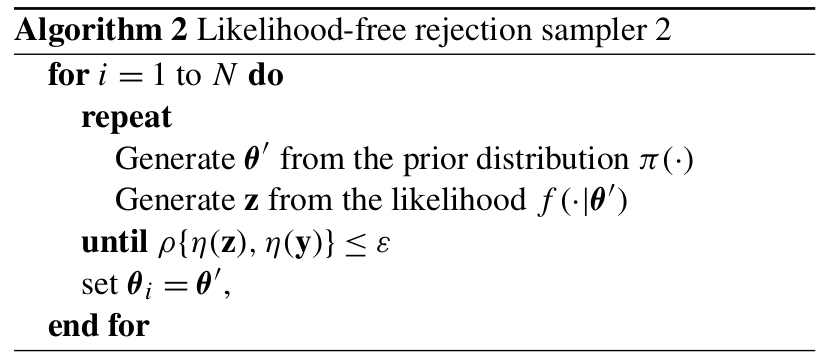

In [ ]:
Image.open('./lfrs_algorithm.png')

We used two methods to calculate the distance $\rho$ between the target and generated timeseries:

- Direct Euclidean distance between the populations:

```python
if measure == "euclidean":
    distance_S = np.linalg.norm(S_gen - S_obs)/population
    distance_I = np.linalg.norm(I_gen - I_obs)/population
    distance_R = np.linalg.norm(R_gen - R_obs)/population
```

- Euclidean distance between the autocorrelations:

```python
autocorr_obs_S = st.acf(S_obs, nlags=len(S_obs))
autocorr_obs_I = st.acf(I_obs, nlags=len(I_obs))
autocorr_obs_R = st.acf(R_obs, nlags=len(R_obs))
...
elif measure == "autocorr":
    distance_S = np.linalg.norm(autocorr_gen_S - autocorr_obs_S)
    distance_I = np.linalg.norm(autocorr_gen_I - autocorr_obs_I)
    distance_R = np.linalg.norm(autocorr_gen_R - autocorr_obs_R)   
```

The samples are accepted if all the distances are smaller than the threshold $\epsilon$:

```python
if (distance_S < epsilon and distance_I < epsilon and distance_R < epsilon):
...
```

The `statsmodel` autocorrelation is defined as follows.\
Let $x$ be a timeseries of length n: the autocorrelation function $A$ at lag $i$ is:

\begin{equation*}
A(i) = \frac{1}{n} \sum_{t=1}^{n-i} (x_t - \bar{x})(x_{t+i} - \bar{x}) \quad \text{for } i > 0 \\
\end{equation*}

where $\bar{x}$ is the mean of the time series $x$. Then is normalized by the zero-lag value.


In the case of the plain euclidean distance, we normalized by the population to have a threshold that is comparable in magnitude with the autocorrelation one: typical values used for the former are $\epsilon = 5, 10, 100$, while for the latter $\epsilon = 0.5,1,2$. Lower thresholds lead in principle to better results, but are computationally unachievable since the acceptance rate is too small.

## Fantasy data

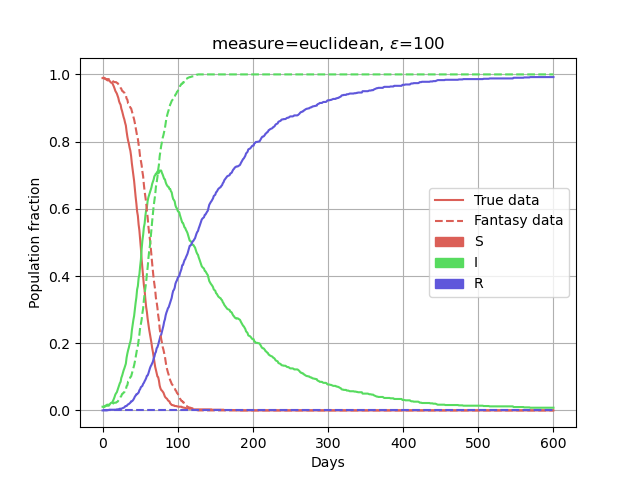

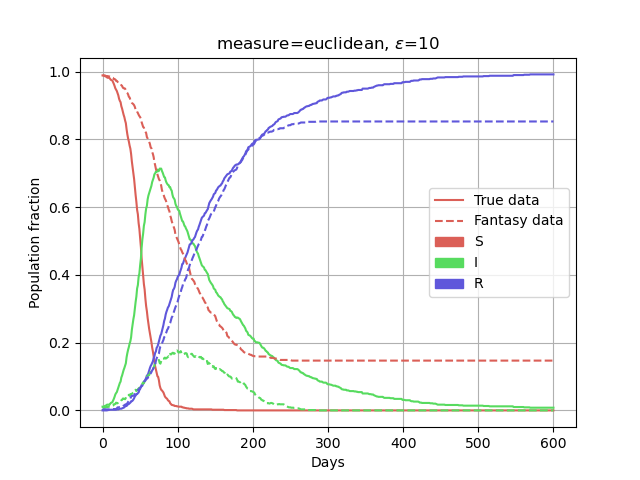

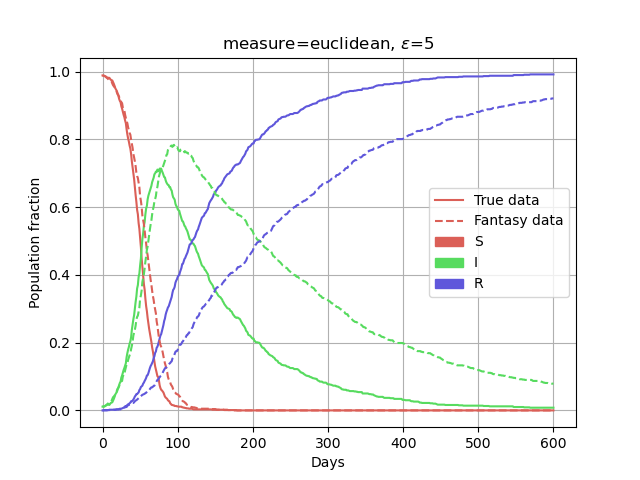

In [ ]:
i1 = Image.open('./results/generated_timeseries/timeseries_100_measure=euclidean_Niter=100000_fantasy_list1.png')
i2 = Image.open('./results/generated_timeseries/timeseries_10_measure=euclidean_Niter=10000_fantasy_list1.png')
i3 = Image.open('./results/generated_timeseries/timeseries_5_measure=euclidean_Niter=10000_fantasy_list0.png')
display(i1, i2, i3)

We see that choosing a smaller $\epsilon$ forces indeed the generated distribution to be more similar to the target. Nevertheless, in this case even the stricter threshold leads to generated data that can be very different from the target. Thus, we do not expect the corresponding posterior estimates to be statistically relevant.

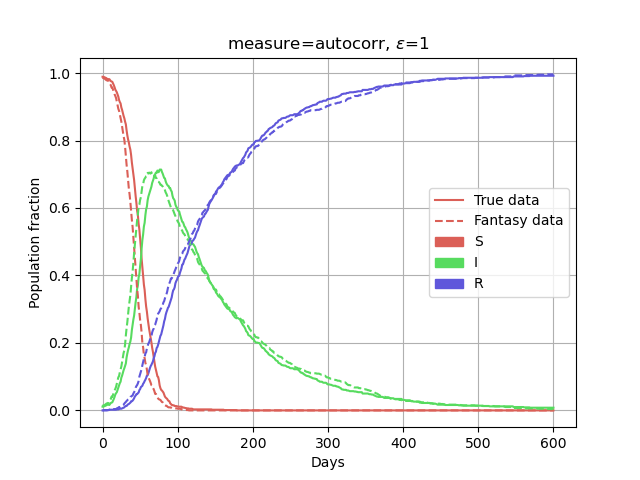

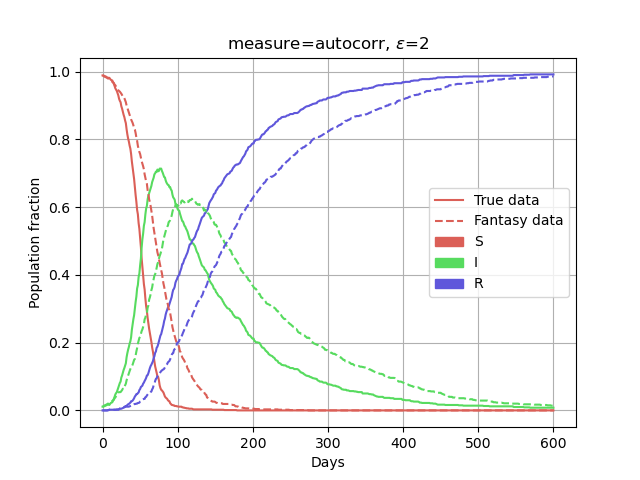

In [ ]:
i4 = Image.open('./results/generated_timeseries/timeseries_2_measure=autocorr_Niter=10000_fantasy_list1.png')
i5 = Image.open('./results/generated_timeseries/timeseries_1_measure=autocorr_Niter=100000_fantasy_list1.png')
display(i4, i5)

The corresponding autorrelations are:

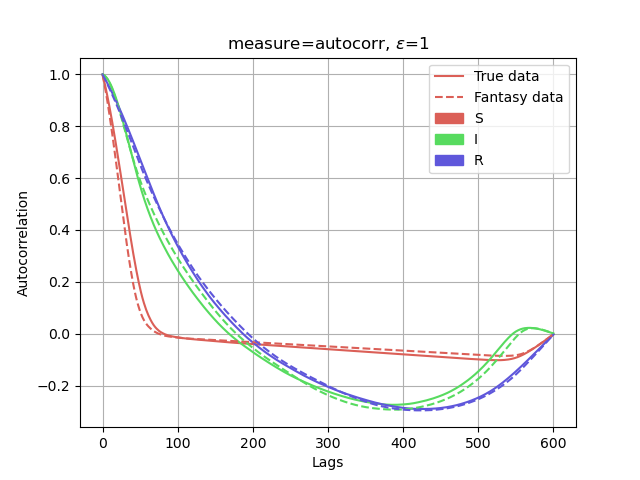

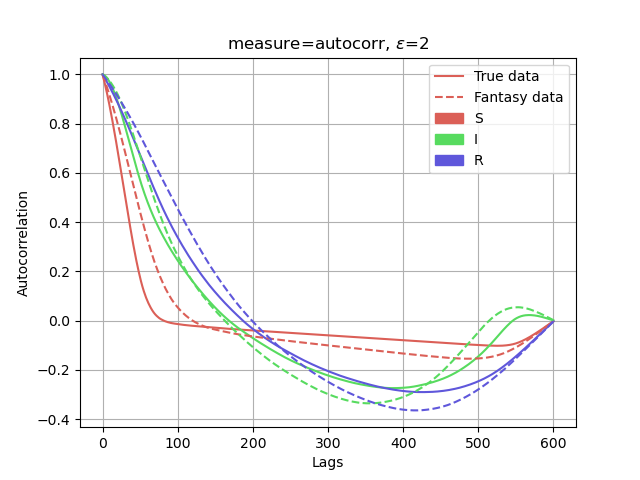

In [ ]:
i6 = Image.open('./results/generated_timeseries/acf_timeseries_2_measure=autocorr_Niter=10000_fantasy_list1.png')
i7 = Image.open('./results/generated_timeseries/acf_timeseries_1_measure=autocorr_Niter=100000_fantasy_list1.png')
display(i6, i7)

Using the distance between the autocorrelations, we can generate more similar data in a manageable amount of time. Thus, we also expect the corresponding histograms to be more peaked around the true values.

## Histograms

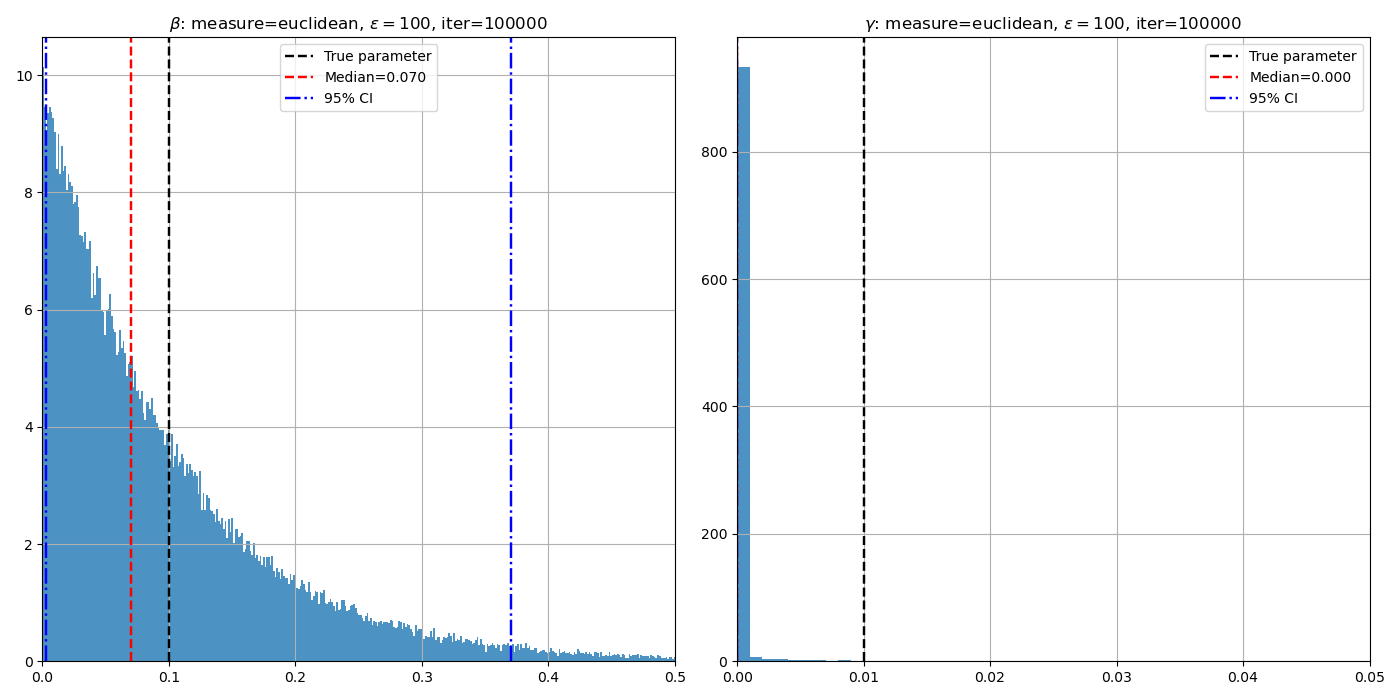

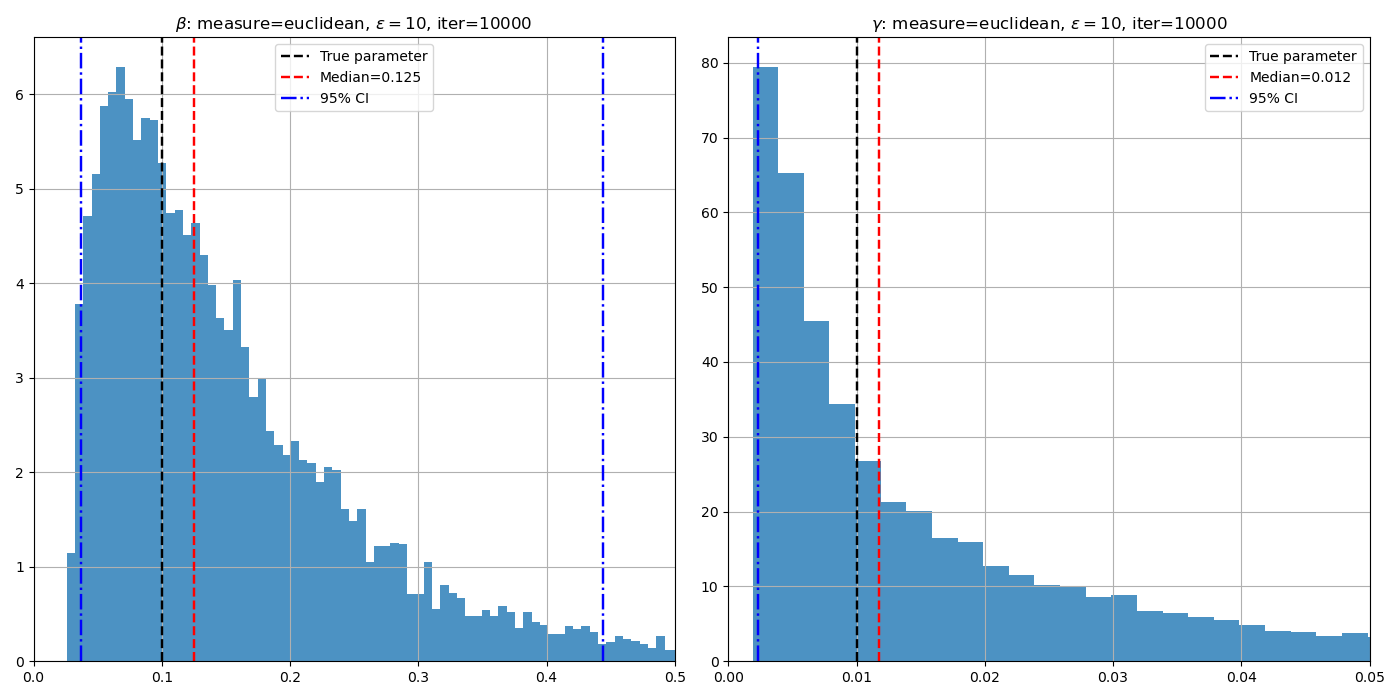

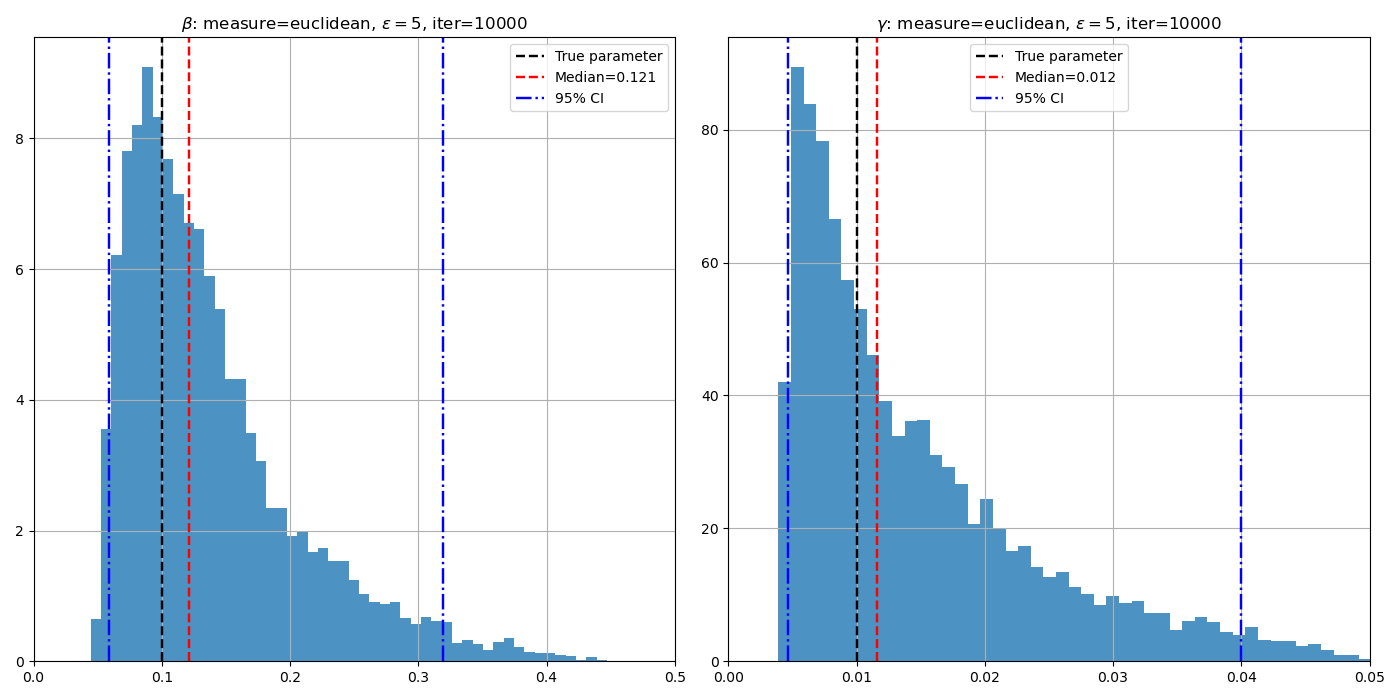

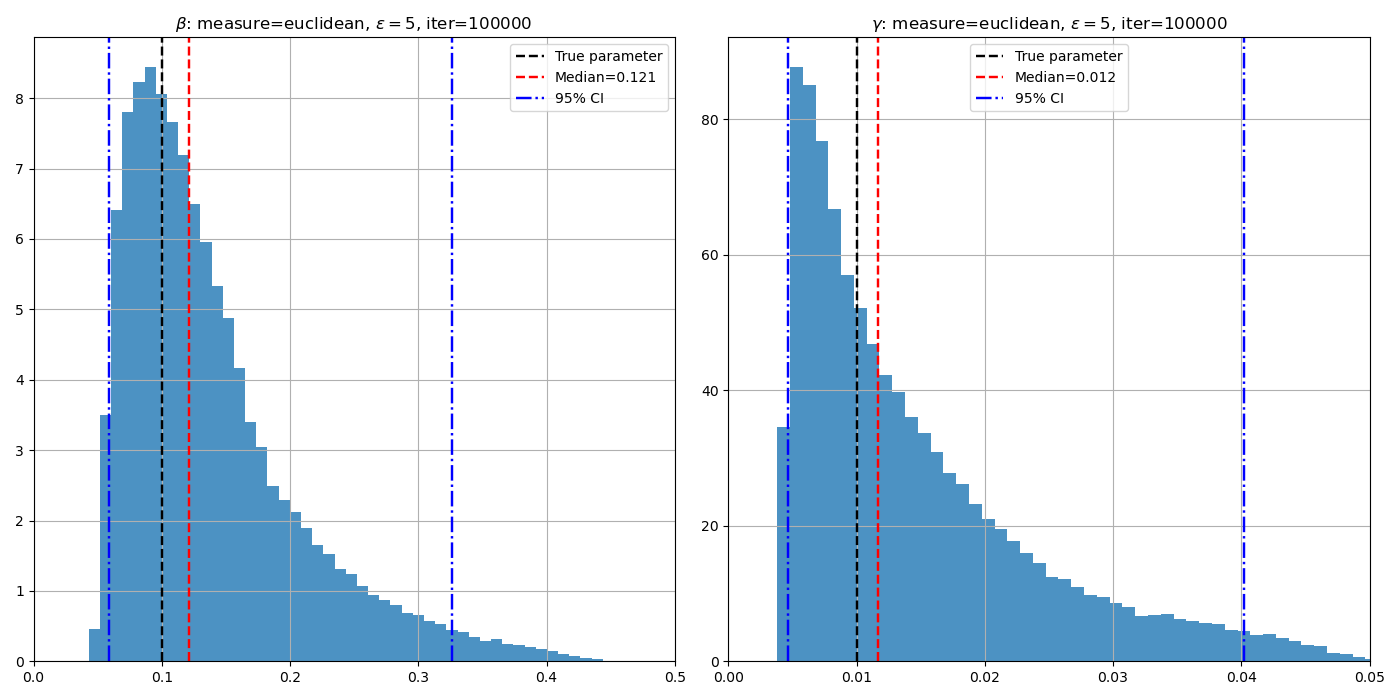

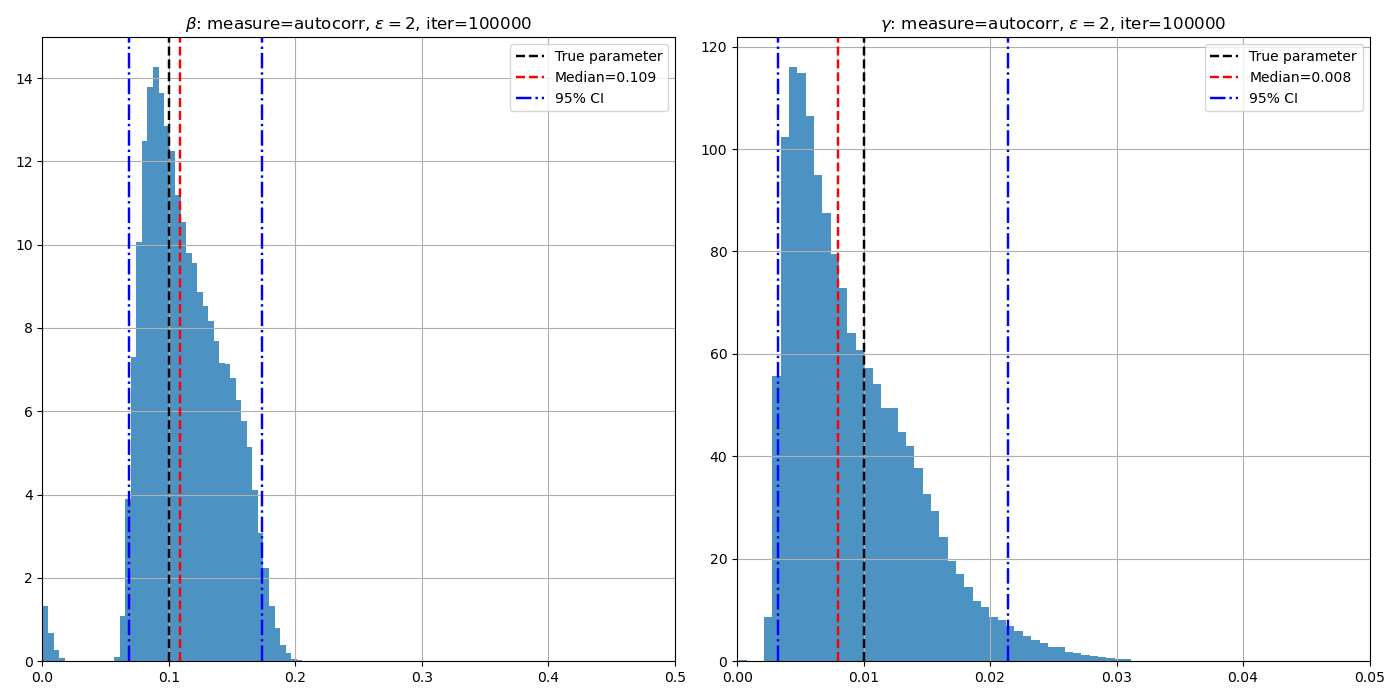

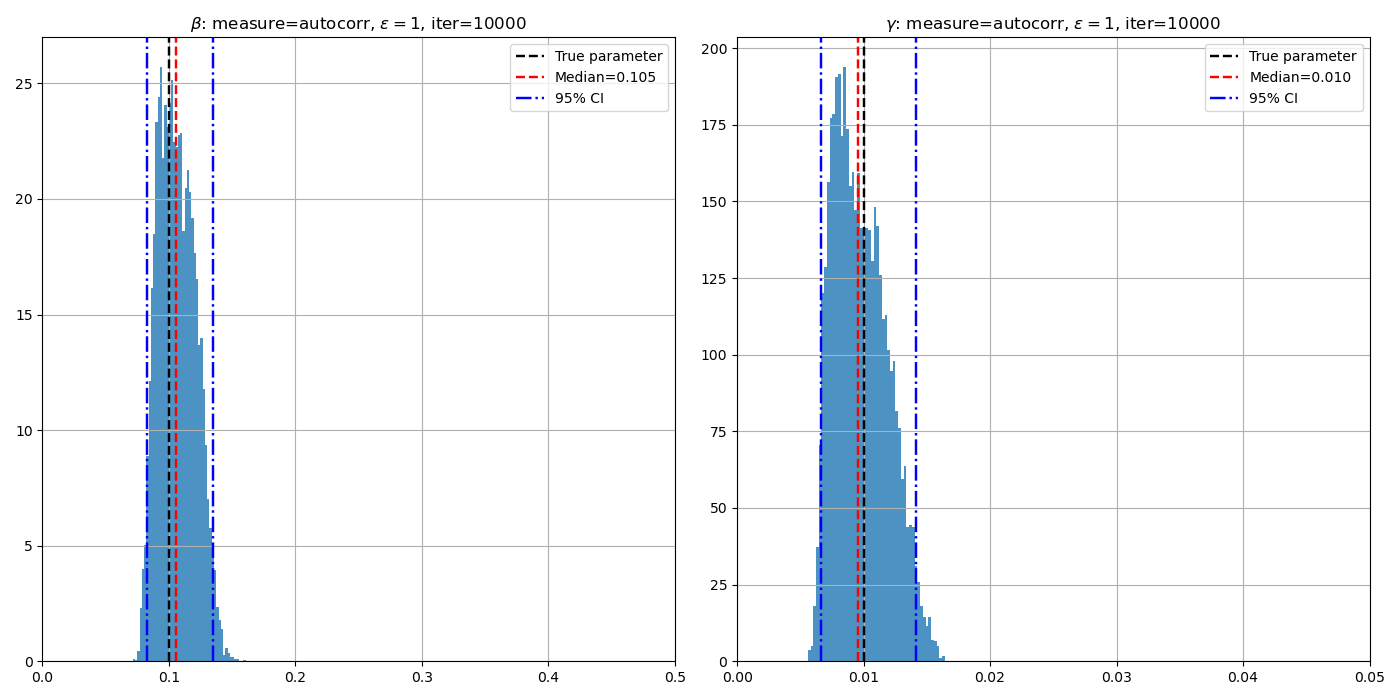

In [ ]:
i8 = Image.open('./results/histograms/rejection_params_hist_epsilon_100_measure_euclidean_Niter_100000.png')
i9 = Image.open('./results/histograms/rejection_params_hist_epsilon_10_measure_euclidean_Niter_10000.png')
i10 = Image.open('./results/histograms/rejection_params_hist_epsilon_5_measure_euclidean_Niter_10000.png')
i11 = Image.open('./results/histograms/rejection_params_hist_epsilon_5_measure_euclidean_Niter_100000.png')
i12 = Image.open('./results/histograms/rejection_params_hist_epsilon_2_measure_autocorr_Niter_100000.png')
i13 = Image.open('./results/histograms/rejection_params_hist_epsilon_1_measure_autocorr_Niter_10000.png')
display(i8, i9, i10, i11, i12, i13)

Increasing by a factor of $10$ (from $10^5$ to $10^6$ samples) with $\epsilon = 5$ does not seem to increase significantly the shape of the posterior and the quality of the inference.\
Choosing the autocorrelation distance the algorithm seems to perform better, and the estimated parameters lie in a sufficiently small credibility interval. Moreover, we see that the choice of $\epsilon$ is yet more important than the number of iterations.


# Likelihood-free MCMC sampler
## Algorithm 3

Now we show the results obtained with an algorithm proposed by Marjoram et al. (2003). The idea is to target the approximate posterior distribution $\pi_{\epsilon}$ by proposing values at high posterior probability regions. The algorithm is the following:



<img src ="./alg3.png">

We run different simulations for various values of the parameters. These are 
* $\epsilon$: tolerance in distance measure (either euclidian distance or autocorrelation)
* $\sigma$ : the standard deviation of the normal distribution used as Markov kernel.

# Choosing $\sigma$

Before delving into the results of the simulations, it is important to highlight the impact of the choice of the parameter $\sigma$ in the convergence time of the chain.

In [2]:
rw1 = np.load("./results/new_autocorr/chain/chain_epsilon=0.5_autocorr_norm=0.0005_Niter=100000.npy",allow_pickle=True)
rw2 = np.load("./results/new_autocorr/chain/chain_epsilon=0.5_autocorr_norm=0.0001_Niter=100000.npy",allow_pickle=True)
rw3 = np.load("./results/new_autocorr/chain/chain_epsilon=0.5_autocorr_norm=5e-05_Niter=100000.npy",allow_pickle=True)
rw4 = np.load("./results/new_autocorr/chain/chain_epsilon=0.5_autocorr_norm=1e-05_Niter=100000.npy",allow_pickle=True)
rw5 = np.load("./results/new_autocorr/chain/chain_epsilon=0.5_autocorr_norm=5e-06_Niter=100000.npy",allow_pickle=True)
rw6 = np.load("./results/new_autocorr/chain/chain_epsilon=0.5_autocorr_norm=1e-06_Niter=100000.npy",allow_pickle=True)

/tmp/ipykernel_1468/1770773685.py:27: MatplotlibDeprecationWarning: The join function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax[i].get_shared_x_axes().join(ax[0], ax[i])


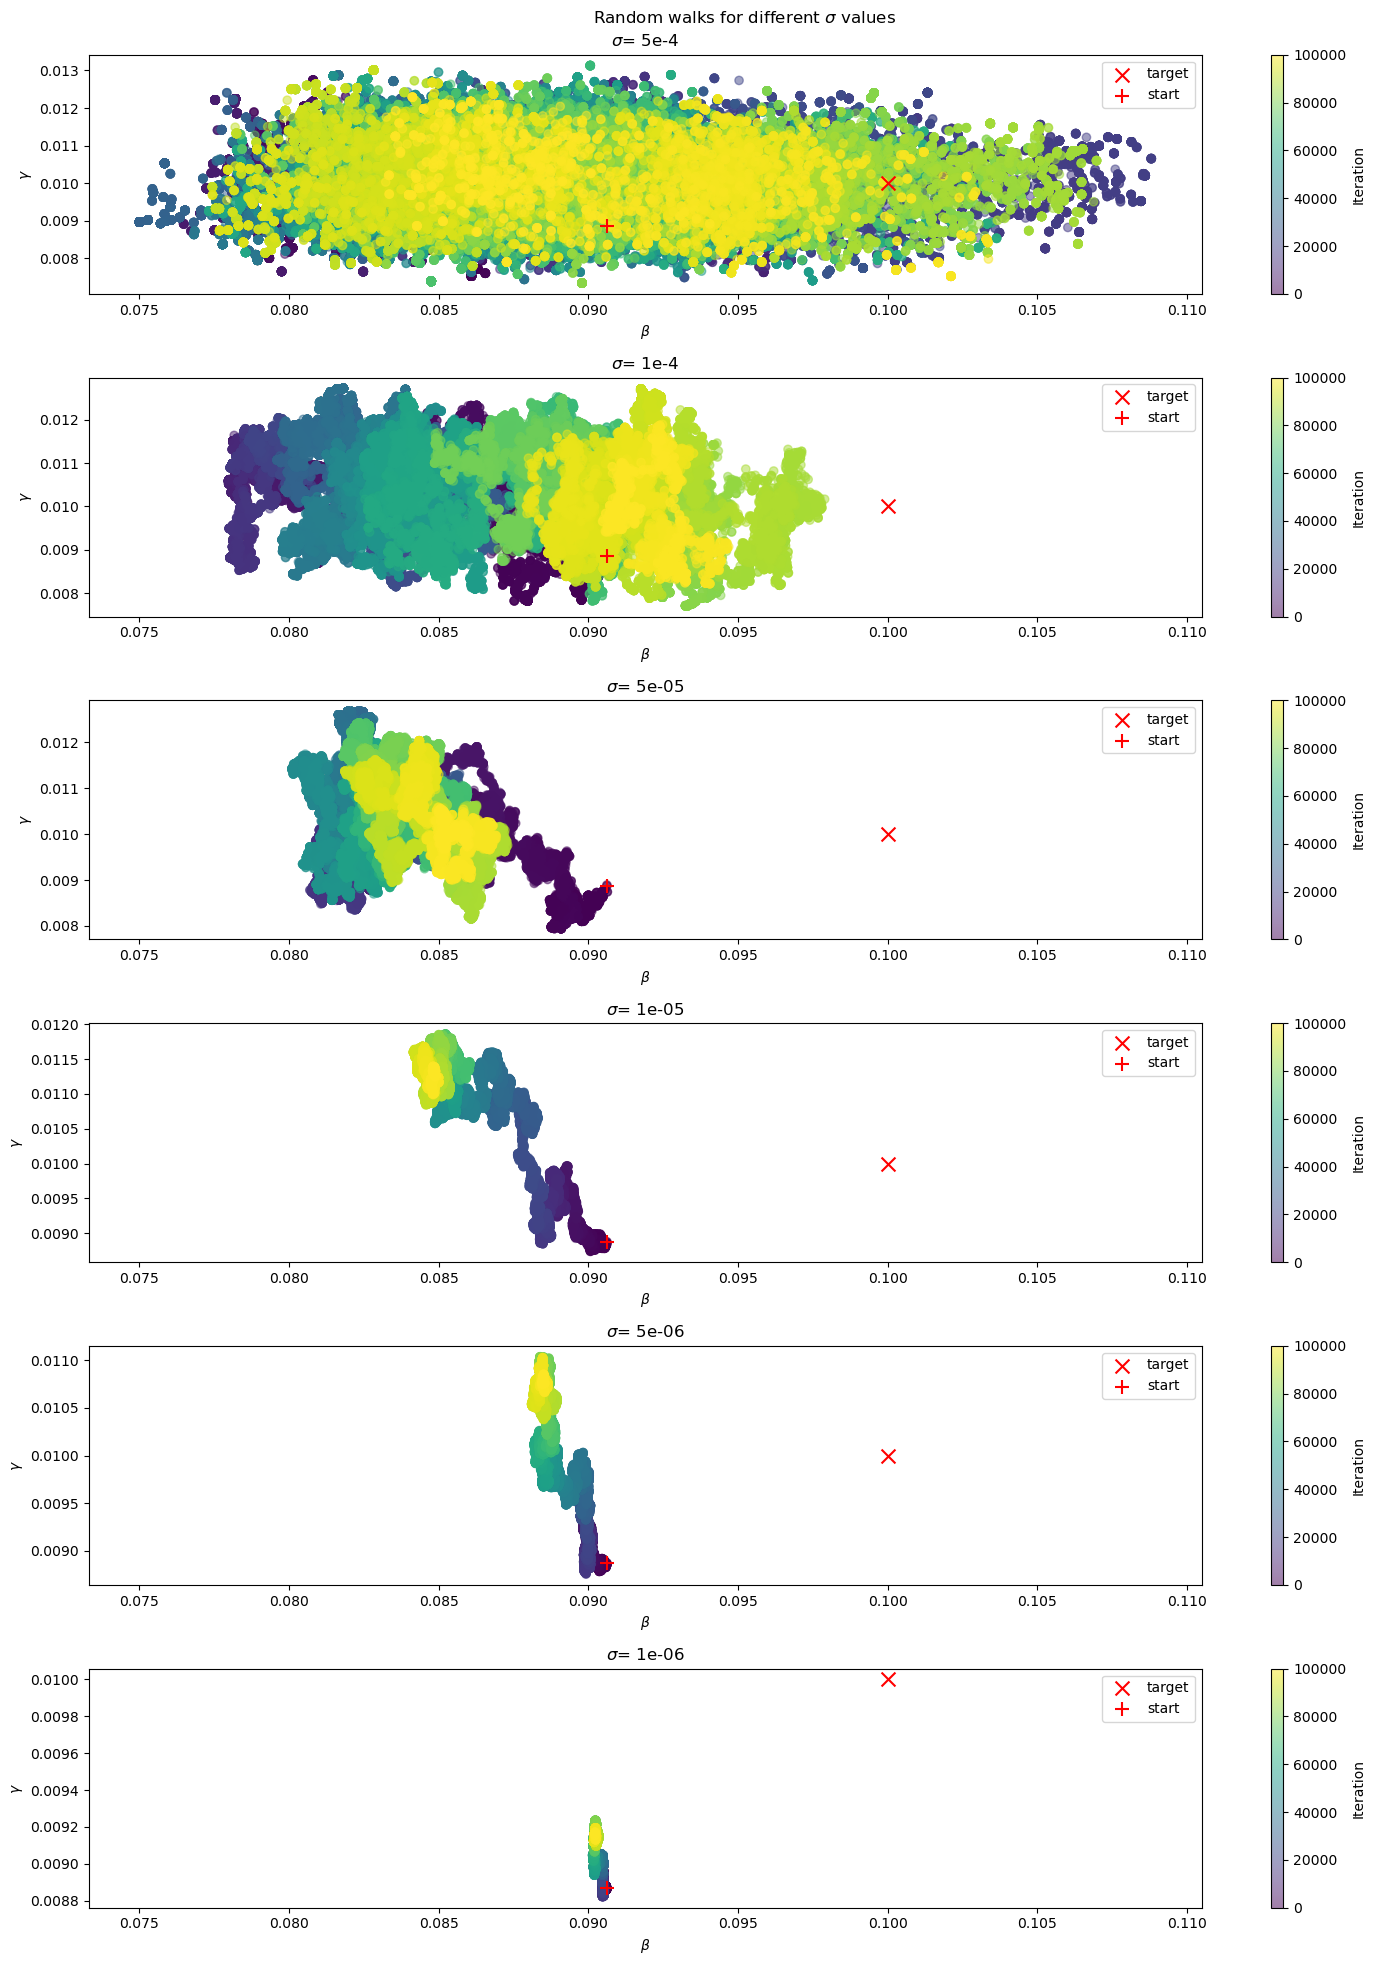

In [3]:
fig, ax = plt.subplots(6, 1, figsize=(15, 20))

titles = [r"$\sigma$" f"= {std}" for std in ["5e-4","1e-4", 5e-5, 1e-5, 5e-6, 1e-6]]

for i, rw in enumerate([rw1, rw2, rw3, rw4, rw5, rw6]):
    sc = ax[i].scatter(rw[:, 0], rw[:, 1], c=np.arange(rw.shape[0]), alpha=0.5, cmap="viridis")
    ax[i].set_title(f"{titles[i]}")
    ax[i].set_xlabel(r"$\beta$")
    ax[i].set_ylabel(r"$\gamma$")
    # Draw an x at target point (0.1,0.01)
    ax[i].scatter(0.1, 0.01, marker='x', color='red',label="target", s=100)
    # Draw a + at starting point
    ax[i].scatter(rw[0, 0], rw[0, 1], marker='+', color='red',label="start", s=100)
    ax[i].legend()


    # add colorbar
    cbar = plt.colorbar(sc, ax=ax[i])
    cbar.set_label("Iteration")

# Set title for the whole figure
fig.suptitle(r"Random walks for different $\sigma$ values" "\n")

# Share x axis 

for i in range(1, 6):
    ax[i].get_shared_x_axes().join(ax[0], ax[i])

plt.tight_layout()

# Euclidean distance

For the result below, the following parameters are used: 

* Number of iterations = 1'000'000
* $\epsilon$ = 5, $\sigma$ = 0.1
* $\epsilon$ = 10, $\sigma$ = 0.1


## Fantasy data 

In [2]:
fdata10_ = np.load("results/euclid/fantasy_data/fantasy_data_epsilon=10_euclid_norm=0.1_Niter=100000.npy",allow_pickle=True)
fdata5_ = np.load("results/euclid/fantasy_data/fantasy_data_epsilon=5_euclidean_norm=0.1_Niter=1000000.npy",allow_pickle=True)

Shape of `fantasy_data` is 

```python 
(n_accepted_samples, Shape_SIR=3, Length of evolution = 601 )
```


`fdata5` has an acceptance rate of $\frac{12'436}{100'000}$ which is $\sim12 \%$.

`fdata10` has an acceptance rate of $\frac{22'712}{100'000}$ which is $\sim23 \%$. 

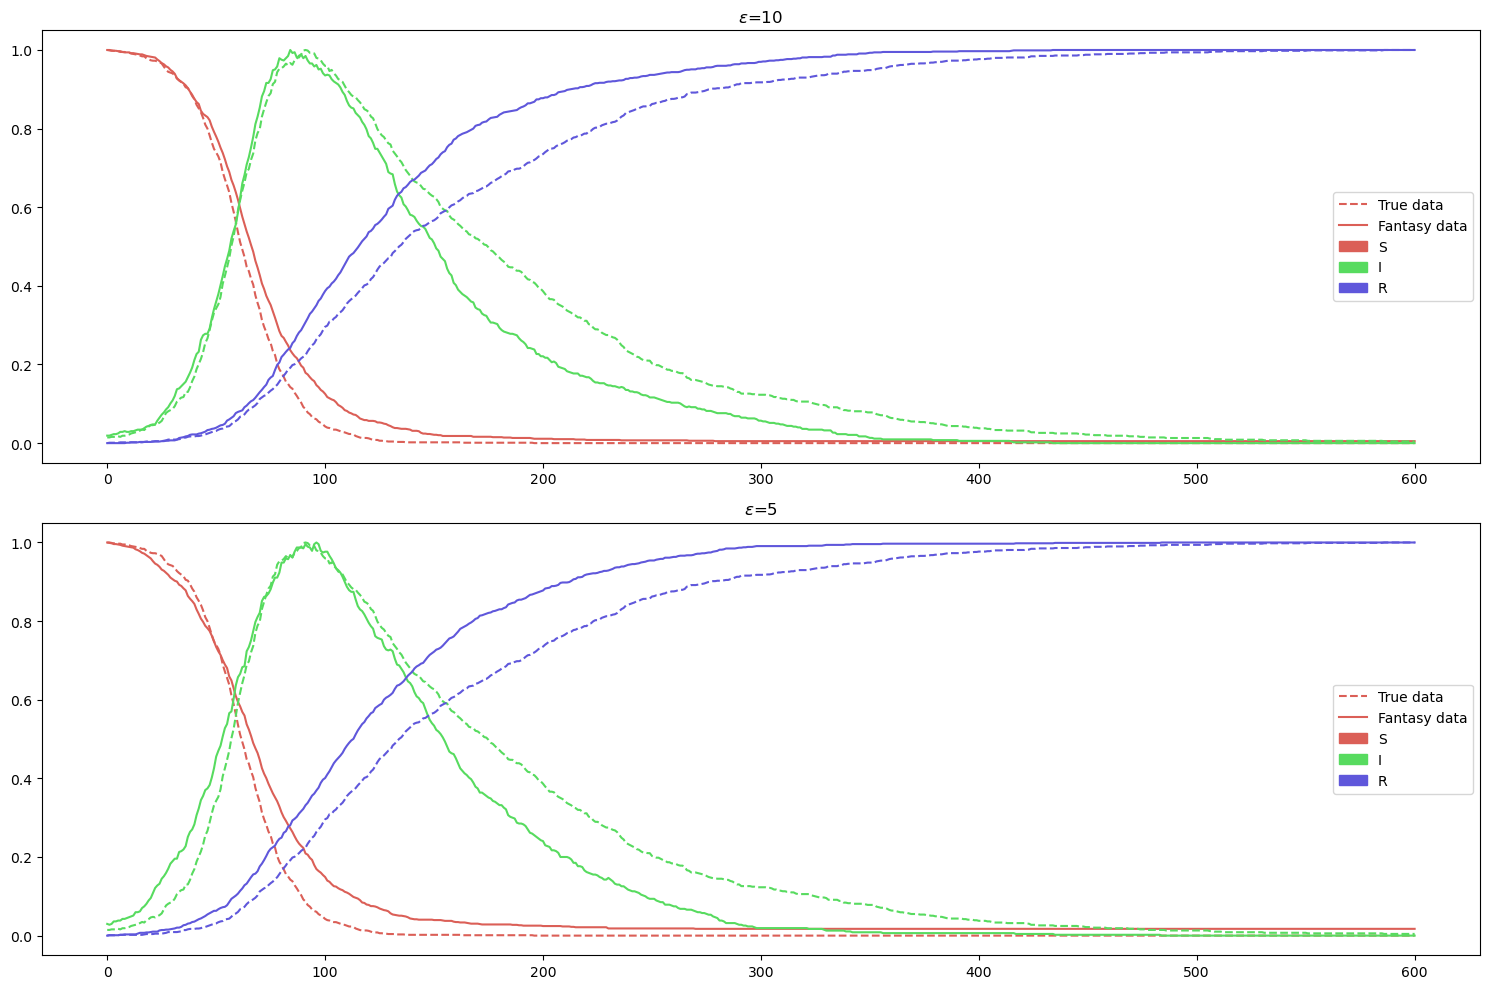

In [10]:
# Plotting the results
fig, ax = plt.subplots(2, 1, figsize=(15, 10))

# Importing target data
target = np.load("./results/euclid/test.npy", allow_pickle=True)

n_run = -50
labels = ["S", "I", "R"]
colors = sns.color_palette("hls", 3)

for i in range(3):
    ax[0].plot(fdata10_[n_run][i]/max(fdata10_[n_run][i]),color=colors[i])
    ax[0].plot(target[i]/max(target[i]), linestyle="--",color=colors[i],)
    ax[1].plot(fdata5_[n_run][i]/max(fdata5_[n_run][i]),color=colors[i])
    ax[1].plot(target[i]/max(target[i]), linestyle="--",color=colors[i])

# Adding titles
ax[0].set_title(r"$\epsilon$=10")
ax[1].set_title(r"$\epsilon$=5")

# Adding legend mlines.Line2D([], [], color='green', linestyle="--" , label='Fantasy data')
fantasy_dot = mlines.Line2D([], [], color=colors[0], linestyle="--", label='True data')
target_dot  = mlines.Line2D([], [], color=colors[0], label='Fantasy data')
SIR_patches = [mpatches.Patch(color=colors[i], label=labels[i]) for i in range(3)]
ax[0].legend(handles=[fantasy_dot, target_dot,SIR_patches[0],SIR_patches[1],SIR_patches[2]])
ax[1].legend(handles=[fantasy_dot, target_dot,SIR_patches[0],SIR_patches[1],SIR_patches[2]])

# Tight layout
plt.tight_layout()




We see that there is not a big difference in the accepted fantasy data between different choices of $\epsilon$

## Chain

Initial condition of the chains are found by iterating once the Alogrithm 2 and using its results as starting point of the chain.

In [7]:
chain5 = np.load("./results/euclid/chain/1_000_000/chain_epsilon=5_euclidean_norm=0.1_Niter=1000000.npy")
chain10 = np.load("./results/euclid/chain/1_000_000/chain_epsilon=10_euclidean_norm=0.1_Niter=1000000.npy")


In [8]:
print("chain5 shape", chain5.shape)
print("chain10 shape", chain10.shape)

chain5 shape (1000001, 2)
chain10 shape (1000001, 2)


### Random walk

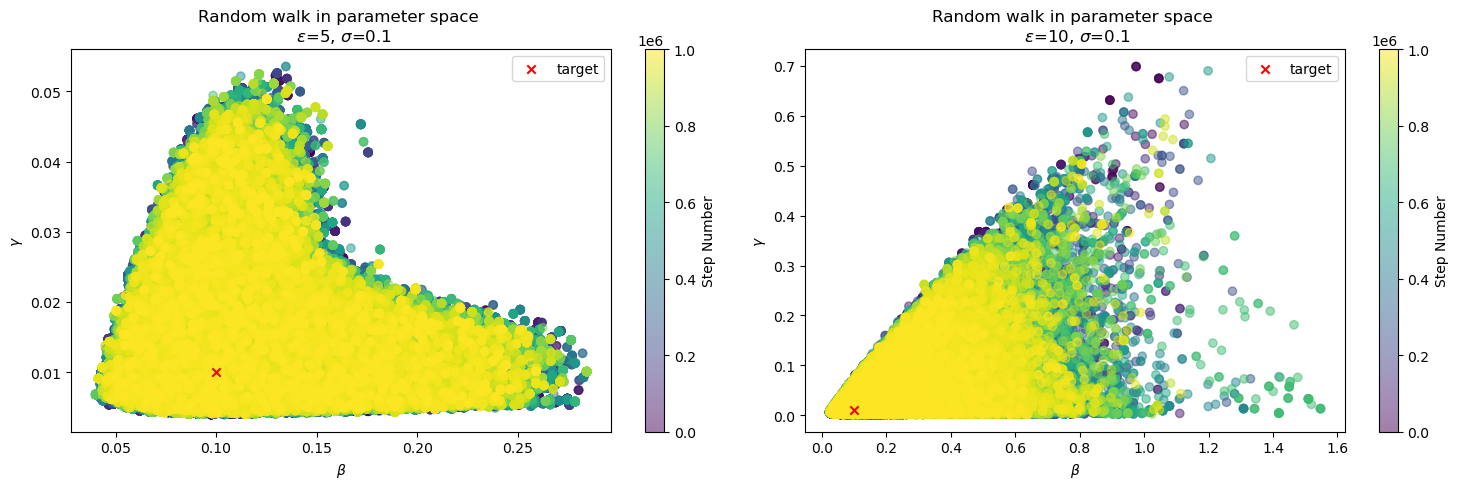

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

sc1 = ax[0].scatter(chain5[:, 0], chain5[:, 1], c=np.arange(chain5.shape[0]), cmap="viridis", alpha=0.5)
ax[0].set_xlabel(r'$\beta$')
ax[0].set_ylabel(r'$\gamma$')
ax[0].set_title("Random walk in parameter space \n $\epsilon$=5, $\sigma$=0.1")

# Draw an x at target point (0.1,0.01)
ax[0].scatter(0.1, 0.01, marker='x', color='red',label="target")

# add legend
ax[0].legend()

# Add colorbar with correct palette
cbar1 = fig.colorbar(sc1, ax=ax[0])

# Set label for colorbar
cbar1.set_label('Step Number')

sc2 = ax[1].scatter(chain10[:, 0], chain10[:, 1], c=np.arange(chain10.shape[0]), cmap='viridis', alpha=0.5)
ax[1].set_xlabel(r'$\beta$')
ax[1].set_ylabel(r'$\gamma$')
ax[1].set_title("Random walk in parameter space \n $\epsilon$=10, $\sigma$=0.1")

# Draw an x at target point (0.1,0.01)
ax[1].scatter(0.1, 0.01, marker='x', color='red',label="target")

# add legend
ax[1].legend()

# Add colorbar with correct palette
cbar2 = fig.colorbar(sc2, ax=ax[1])

# Set label for colorbar
cbar2.set_label('Step Number')

plt.tight_layout()

### Burn-in and autocorrelation

/tmp/ipykernel_1468/942576272.py:35: MatplotlibDeprecationWarning: The join function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax[0, 0].get_shared_y_axes().join(ax[0, 0], ax[0, 1])
/tmp/ipykernel_1468/942576272.py:36: MatplotlibDeprecationWarning: The join function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax[1, 0].get_shared_y_axes().join(ax[1, 0], ax[1, 1])


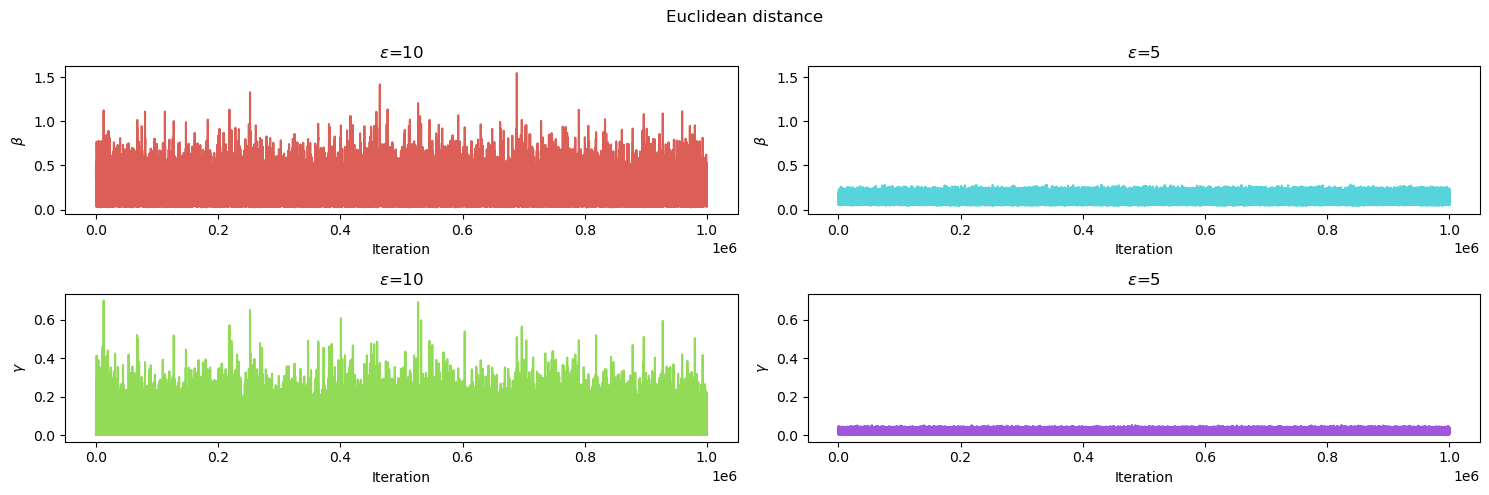

In [10]:
# Plotting the results
fig, ax = plt.subplots(2, 2, figsize=(15, 5))

colors = sns.color_palette("hls", 4)

# Plotting the chains
ax[0, 0].plot(chain10[:,0], color=colors[0],label = "beta")
ax[1, 0].plot(chain10[:,1], color=colors[1],label = "gamma")
ax[0, 1].plot(chain5[:,0], color=colors[2],label = "beta")
ax[1, 1].plot(chain5[:,1], color=colors[3],label = "gamma")

# Adding titles
ax[0, 0].set_title(r"$\epsilon$=10")
ax[1, 0].set_title(r"$\epsilon$=10")
ax[0, 1].set_title(r"$\epsilon$=5")
ax[1, 1].set_title(r"$\epsilon$=5")



# Adding labels
ax[0, 0].set_xlabel("Iteration")
ax[1, 0].set_xlabel("Iteration")
ax[0, 1].set_xlabel("Iteration")
ax[1, 1].set_xlabel("Iteration")

# Adding y labels
ax[0, 0].set_ylabel(r"$\beta$")
ax[1, 0].set_ylabel(r"$\gamma$")
ax[0, 1].set_ylabel(r"$\beta$")
ax[1, 1].set_ylabel(r"$\gamma$")



# Share y axis
ax[0, 0].get_shared_y_axes().join(ax[0, 0], ax[0, 1])
ax[1, 0].get_shared_y_axes().join(ax[1, 0], ax[1, 1])

# Set title to the whole figure
fig.suptitle("Euclidean distance")

# Tight layout
plt.tight_layout()

All chains converge almost immediately. We see that the chain relative to $\epsilon$ = 5 has much less variance with respect to $\epsilon$ = 10.

A value of `burn-in` = 100 is chosen.

Select a burn-in value and check autocorrelation. Then plot the autocorrelation function for the two chains. This will help deciding the lag of the chain.

In [11]:
def correlate(x):
    return st.acf(x, nlags=len(x))

In [12]:
burn_in = 100

Both gamma-chains autocorrelations drop after $\sim 100$ samples. This will be the lag value to choose.

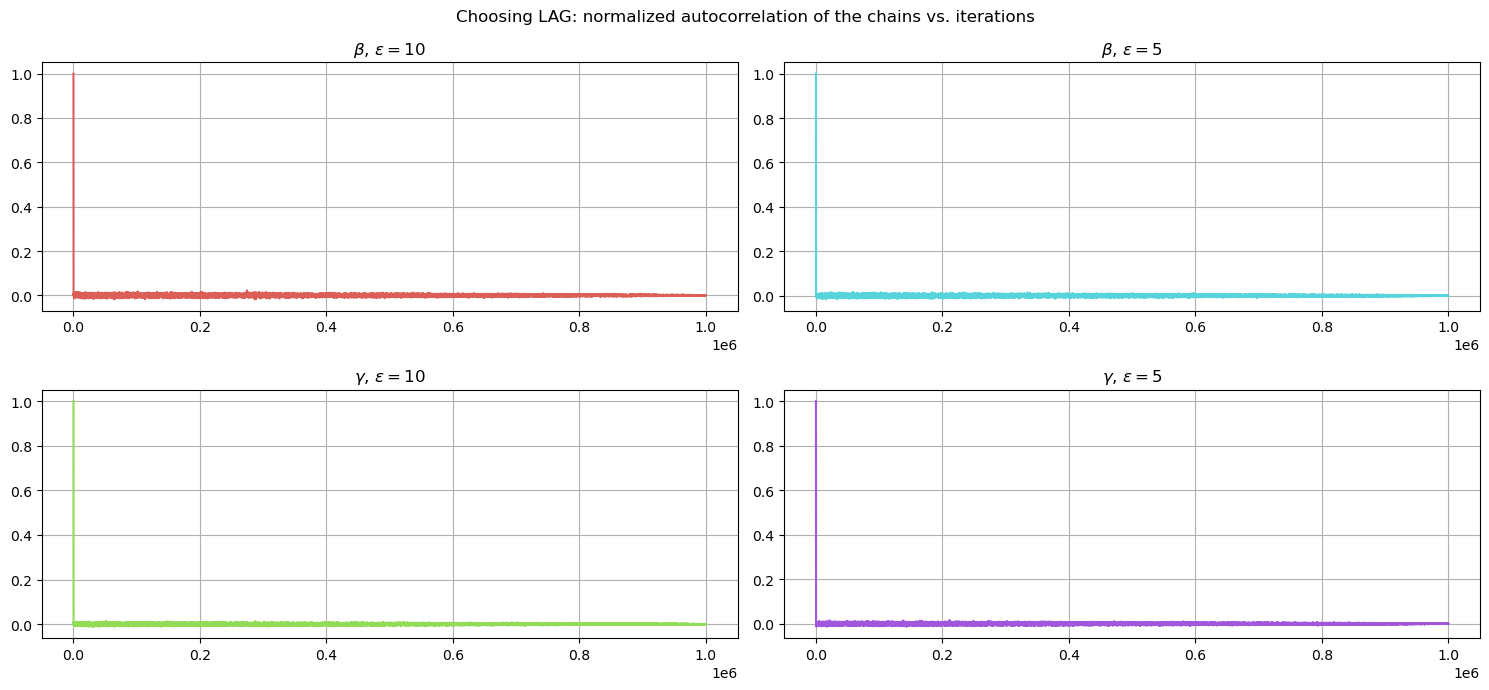

In [13]:
fig,ax = plt.subplots(2,2,figsize=(15,7))


colors = sns.color_palette("hls", 4)


ax[0,0].plot(correlate(chain10[burn_in:,0])/max(correlate(chain10[burn_in:,0])),color=colors[0],alpha=1)
ax[0,0].set_title(r'$\beta$, $\epsilon=10$')
ax[0,0].grid()

ax[1,0].plot(correlate(chain10[burn_in:,1])/max(correlate(chain10[burn_in:,1])),color=colors[1],alpha=1)
ax[1,0].set_title(r'$\gamma$, $\epsilon=10$')
ax[1,0].grid()

ax[0,1].plot(correlate(chain5[burn_in:,0])/max(correlate(chain5[burn_in:,0])),color=colors[2],alpha=1)
ax[0,1].set_title(r'$\beta$, $\epsilon=5$')
ax[0,1].grid()

ax[1,1].plot(correlate(chain5[burn_in:,1])/max(correlate(chain5[burn_in:,1])),color=colors[3],alpha=1)
ax[1,1].set_title(r'$\gamma$, $\epsilon=5$')
ax[1,1].grid()


fig.suptitle("Choosing LAG: normalized autocorrelation of the chains vs. iterations")

plt.tight_layout()

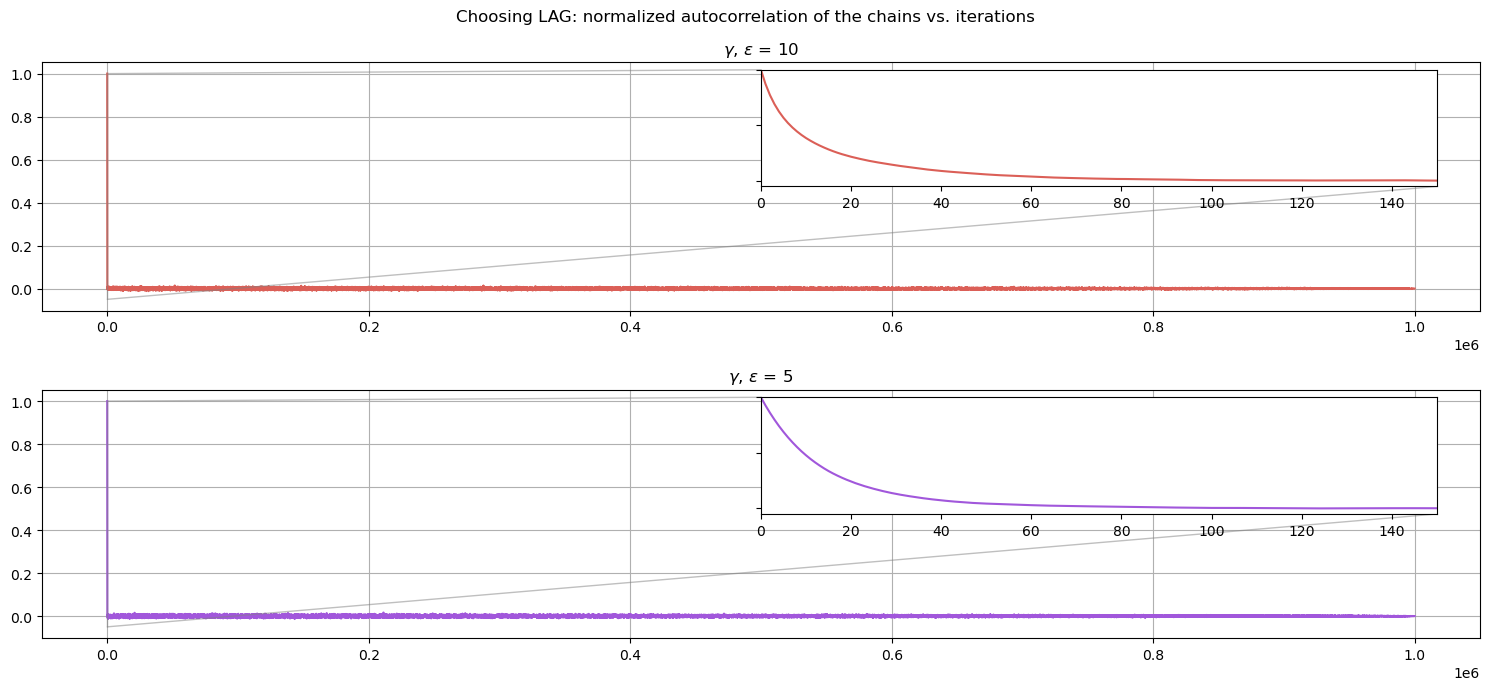

In [14]:
fig, ax = plt.subplots(2,figsize=(15,7))


ax[0].plot(correlate(chain10[burn_in:,1])/max(correlate(chain10[burn_in:,1])),color=colors[0],alpha=1)


# inset axes....
x1, x2, y1, y2 = 0, 150, -.05, 1  # subregion of the original image

axins = ax[0].inset_axes(
    [0.5, 0.5, 0.47, 0.47],
    xlim=(x1, x2), ylim=(y1, y2), xticklabels=[], yticklabels=[])

ax[0].indicate_inset_zoom(axins)

axins.plot(correlate(chain10[burn_in:,1])/max(correlate(chain10[burn_in:,1])),color=colors[0],alpha=1)

# add xticks with numbers to the inset axes
axins.set_xticks(np.arange(x1,x2,20), labels=np.arange(x1,x2,20))


ax[0].set_title(r"$\gamma$, $\epsilon$ = 10")

axins2 = ax[1].inset_axes(
    [0.5, 0.5, 0.47, 0.47],
    xlim=(x1, x2), ylim=(y1, y2), xticklabels=[], yticklabels=[])

ax[1].plot(correlate(chain5[burn_in:,1])/max(correlate(chain5[burn_in:,1])),color=colors[3],alpha=1)

ax[1].set_title(r"$\gamma$, $\epsilon$ = 5")

ax[1].indicate_inset_zoom(axins2)
axins2.set_xticks(np.arange(x1,x2,20), labels=np.arange(x1,x2,20))
axins2.plot(correlate(chain5[burn_in:,1])/max(correlate(chain5[burn_in:,1])),color=colors[3],alpha=1)

# add grids
ax[0].grid()
ax[1].grid()


fig.suptitle("Choosing LAG: normalized autocorrelation of the chains vs. iterations")
plt.tight_layout()

We choose  `lag = 100` and `burn-in = 100`

## Posteriors

In [15]:
lag = 100
chain10[burn_in::lag,1].shape

(10000,)

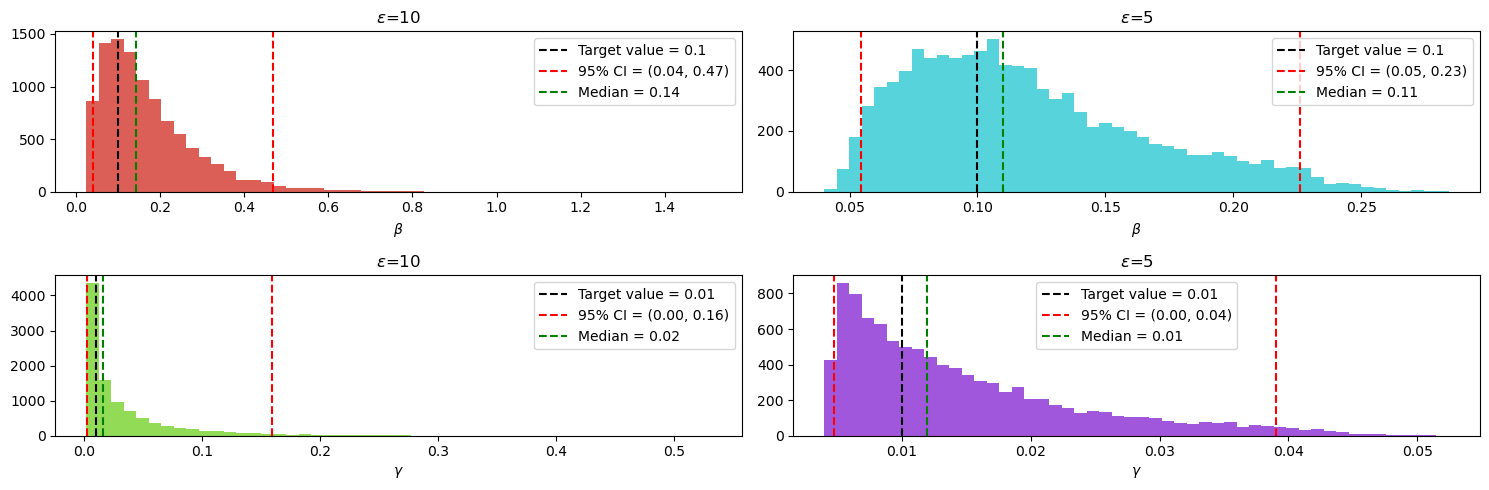

In [16]:
# Histograms of the chains
fig, ax = plt.subplots(2, 2, figsize=(15, 5))


bins = 50

# Plotting the chains
ax[0, 0].hist(chain10[burn_in::lag,0], color=colors[0], bins=bins)
ax[1, 0].hist(chain10[burn_in::lag,1], color=colors[1], bins=bins)
ax[0, 1].hist(chain5[burn_in::lag,0], color=colors[2], bins=bins)
ax[1, 1].hist(chain5[burn_in::lag,1], color=colors[3], bins=bins)

# Add vertical lines for the true values
# true values are beta=0.1 and gamma=0.01
ax[0, 0].axvline(0.1, color="black", linestyle="--",label="Target value = 0.1")
ax[1, 0].axvline(0.01, color="black", linestyle="--",label="Target value = 0.01")
ax[0, 1].axvline(0.1, color="black", linestyle="--", label="Target value = 0.1")
ax[1, 1].axvline(0.01, color="black", linestyle="--", label="Target value = 0.01")

# Adding 95% confidence intervals and median
ax[0, 0].axvline(np.percentile(chain10[burn_in::lag,0], 2.5), color="red", linestyle="--",
                 label=f"95% CI = ({np.percentile(chain10[burn_in::lag,0], 2.5):.2f}, {np.percentile(chain10[burn_in::lag,0], 97.5):.2f})")
ax[0, 0].axvline(np.percentile(chain10[burn_in::lag,0], 97.5), color="red", linestyle="--")

ax[0, 0].axvline(np.median(chain10[burn_in::lag,0]), color="green", linestyle="--", label=f"Median = {np.median(chain10[burn_in::lag,0]):.2f}")

ax[1, 0].axvline(np.percentile(chain10[burn_in::lag,1], 2.5), color="red", linestyle="--",
                    label=f"95% CI = ({np.percentile(chain10[burn_in::lag,1], 2.5):.2f}, {np.percentile(chain10[burn_in::lag,1], 97.5):.2f})")
ax[1, 0].axvline(np.percentile(chain10[burn_in::lag,1], 97.5), color="red", linestyle="--")

ax[1, 0].axvline(np.median(chain10[burn_in::lag,1]), color="green", linestyle="--", label=f"Median = {np.median(chain10[burn_in::lag,1]):.2f}")

ax[0, 1].axvline(np.percentile(chain5[burn_in::lag,0], 2.5), color="red", linestyle="--",
                    label=f"95% CI = ({np.percentile(chain5[burn_in::lag,0], 2.5):.2f}, {np.percentile(chain5[burn_in::lag,0], 97.5):.2f})")
ax[0, 1].axvline(np.percentile(chain5[burn_in::lag,0], 97.5), color="red", linestyle="--")

ax[0, 1].axvline(np.median(chain5[burn_in::lag,0]), color="green", linestyle="--", label=f"Median = {np.median(chain5[burn_in::lag,0]):.2f}")

ax[1, 1].axvline(np.percentile(chain5[burn_in::lag,1], 2.5), color="red", linestyle="--",
                    label=f"95% CI = ({np.percentile(chain5[burn_in::lag,1], 2.5):.2f}, {np.percentile(chain5[burn_in::lag,1], 97.5):.2f})")
ax[1, 1].axvline(np.percentile(chain5[burn_in::lag,1], 97.5), color="red", linestyle="--")

ax[1, 1].axvline(np.median(chain5[burn_in::lag,1]), color="green", linestyle="--", label=f"Median = {np.median(chain5[burn_in::lag,1]):.2f}")



# Adding titles
ax[0, 0].set_title(r"$\epsilon$=10")
ax[1, 0].set_title(r"$\epsilon$=10")
ax[0, 1].set_title(r"$\epsilon$=5")
ax[1, 1].set_title(r"$\epsilon$=5")

# Adding labels
ax[0, 0].set_xlabel(r"$\beta$")
ax[1, 0].set_xlabel(r"$\gamma$")
ax[0, 1].set_xlabel(r"$\beta$")
ax[1, 1].set_xlabel(r"$\gamma$")


# Adding legend
ax[0, 0].legend()
ax[1, 0].legend()
ax[0, 1].legend()
ax[1, 1].legend()

# Tight layout
plt.tight_layout()

We see that the algorithm correctly estimates the parameter value for both values of epsilon.
We now see how it performs using the autocorrelation of the time series as distance measure.

# Autocorrelation distance

Results of algorithm 3 using autocorrelation as a measure of distance.


* Number of iterations = 1'000'000

* Standard deviation of normal distribution (Markov kernel): $\sigma$ = 0.001

## Fantasy data

In [17]:
fdata1 = np.load("results/new_autocorr/fantasy_data/fantasy_data_epsilon=1_autocorr_norm=0.001_Niter=1000000.npy",allow_pickle=True)
fdata3 = np.load("results/new_autocorr/fantasy_data/fantasy_data_epsilon=0.5_autocorr_norm=0.001_Niter=1000000.npy",allow_pickle=True)

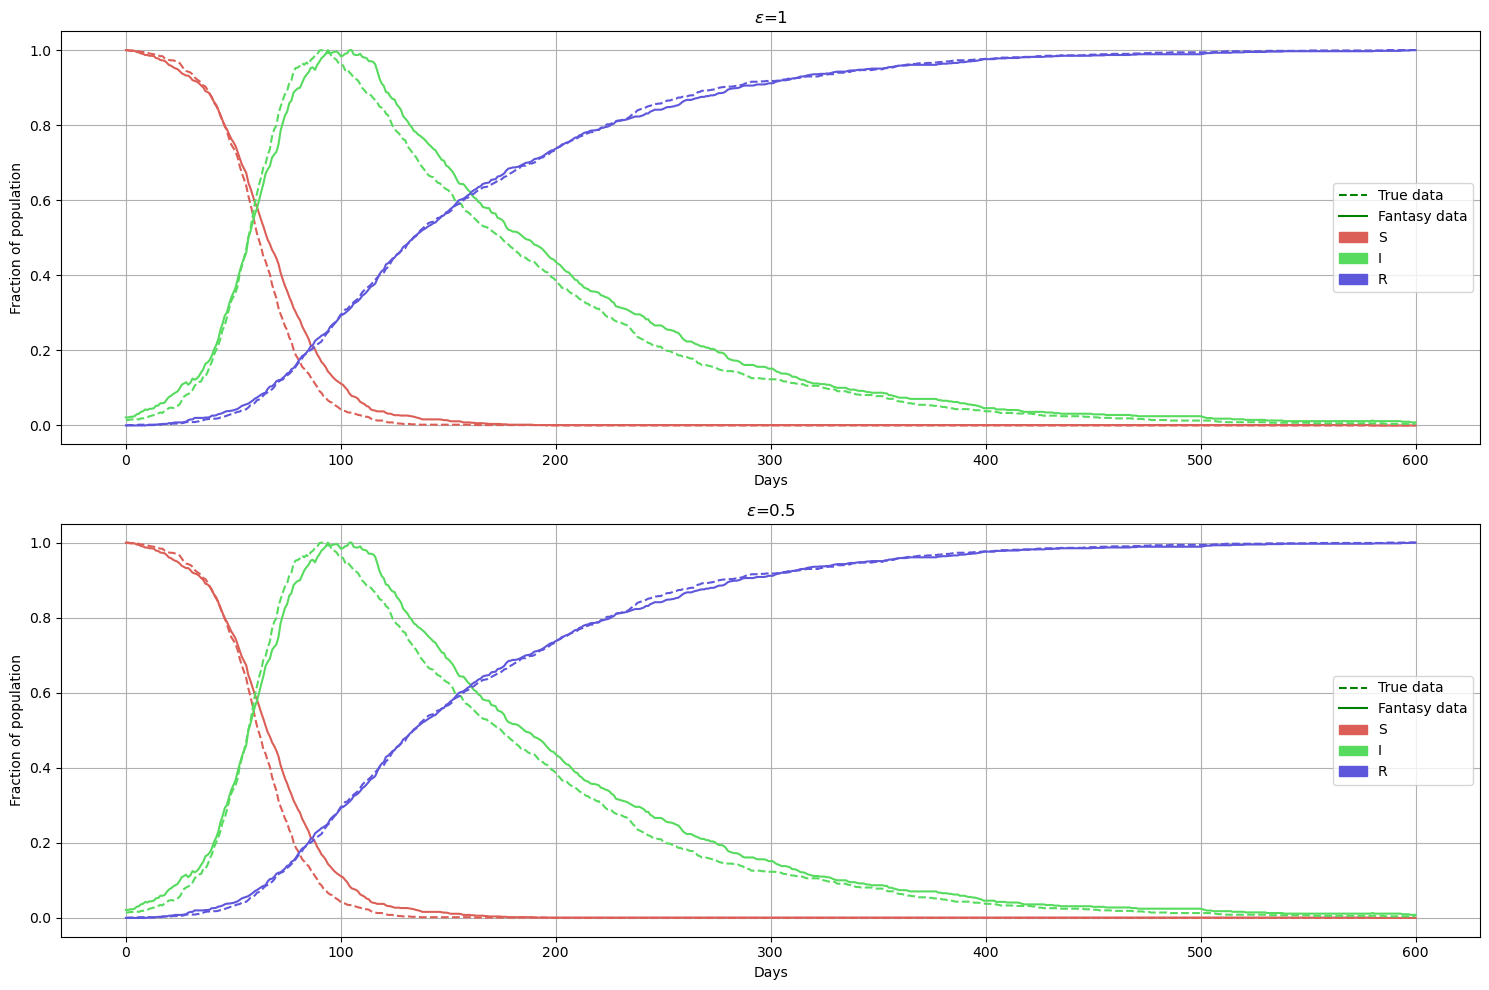

In [18]:
# Plotting the results
fig, ax = plt.subplots(2, 1, figsize=(15, 10))

# Importing target data
target = np.load("./results/new_autocorr/target_data_6-04-1118.npy", allow_pickle=True)

n_run = -1
labels = ["S", "I", "R"]
colors = sns.color_palette("hls", 3)

for i in range(3):
    ax[0].plot(fdata1[n_run][i]/max(fdata1[n_run][i]),color=colors[i])
    ax[0].plot(target[i]/max(target[i]), linestyle="--",color=colors[i])
    ax[1].plot(fdata1[n_run][i]/max(fdata1[n_run][i]),color=colors[i])
    ax[1].plot(target[i]/max(target[i]), linestyle="--",color=colors[i])

# Adding titles
ax[0].set_title(r"$\epsilon$=1")
ax[1].set_title(r"$\epsilon$=0.5")

# Adding legend mlines.Line2D([], [], color='green', linestyle="--" , label='Fantasy data')
fantasy_dot = mlines.Line2D([], [], color='green', linestyle="--", label='True data')
target_dot  = mlines.Line2D([], [], color='green', label='Fantasy data')
SIR_patches = [mpatches.Patch(color=colors[i], label=labels[i]) for i in range(3)]
ax[0].legend(handles=[fantasy_dot, target_dot,SIR_patches[0],SIR_patches[1],SIR_patches[2]])
ax[1].legend(handles=[fantasy_dot, target_dot,SIR_patches[0],SIR_patches[1],SIR_patches[2]])

# set y label
ax[0].set_ylabel("Fraction of population")
ax[1].set_ylabel("Fraction of population")

# set x label
ax[0].set_xlabel("Days")
ax[1].set_xlabel("Days")

# add grid
ax[0].grid()
ax[1].grid()


# Tight layout
plt.tight_layout()




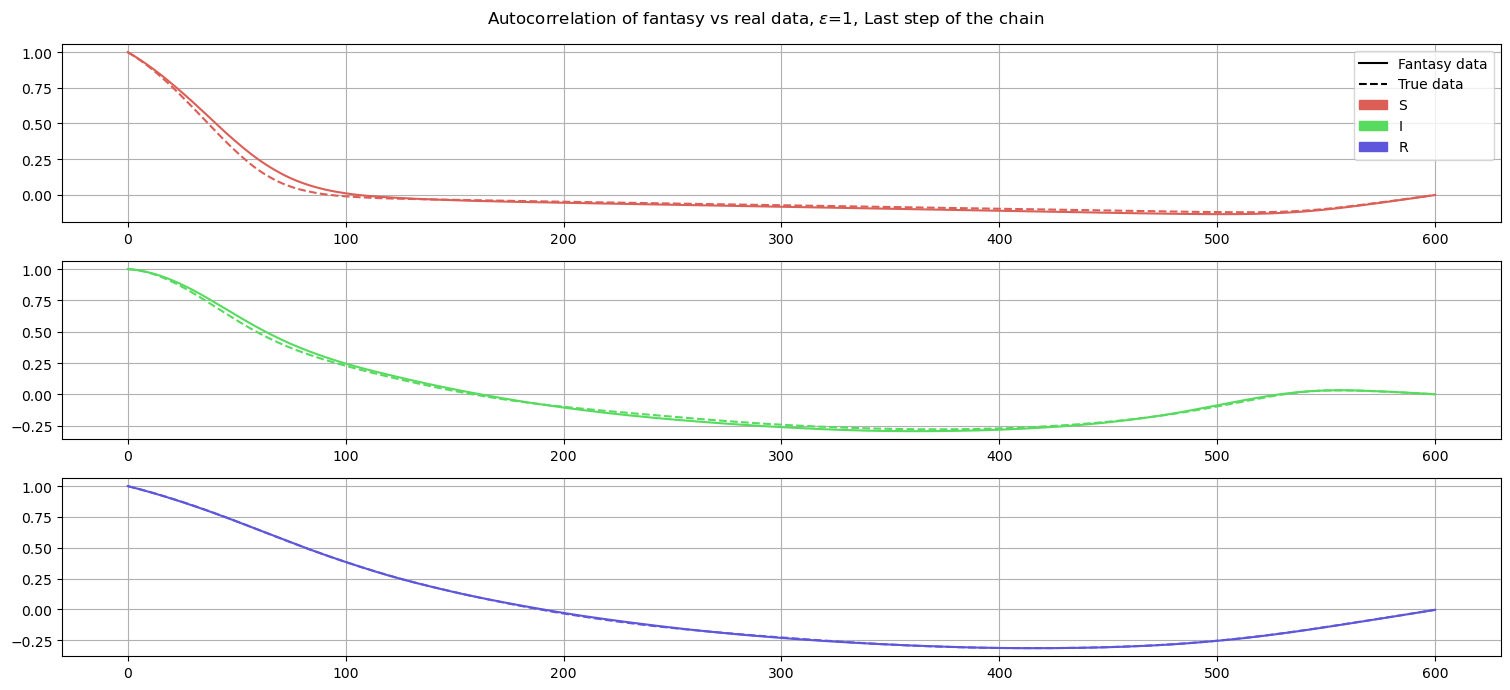

In [19]:
# Plot autocorrelation

fig,ax = plt.subplots(3,1,figsize=(15,7))
colors = sns.color_palette("hls", 3)

n_run = -1
titles = ["S","I","R"]
for i in range(len(ax)):
    ax[i].plot(correlate(fdata1[n_run][i]),color=colors[i])
    ax[i].plot(correlate(target[i]),color=colors[i],linestyle="--")
    ax[i].grid()
# set title for whole figure
fig.suptitle("Autocorrelation of fantasy vs real data, $\epsilon$=1, Last step of the chain")

# set legend for first subplot
fantasy_dot = mlines.Line2D([], [], color="black", label='Fantasy data',linestyle="-")
target_dot  = mlines.Line2D([], [], color="black", label='True data',linestyle="--")
# palette for SIR
SIR_patches = [mpatches.Patch(color=colors[i], label=titles[i]) for i in range(3)]
ax[0].legend(handles=[fantasy_dot, target_dot,SIR_patches[0],SIR_patches[1],SIR_patches[2]])


plt.tight_layout()

## Chains

### Random walk

In [20]:
chain1 = np.load("./results/new_autocorr/chain/chain_epsilon=1_autocorr_norm=0.001_Niter=1000000.npy")
chain3 = np.load("./results/new_autocorr/chain/chain_epsilon=0.5_autocorr_norm=0.001_Niter=1000000.npy")

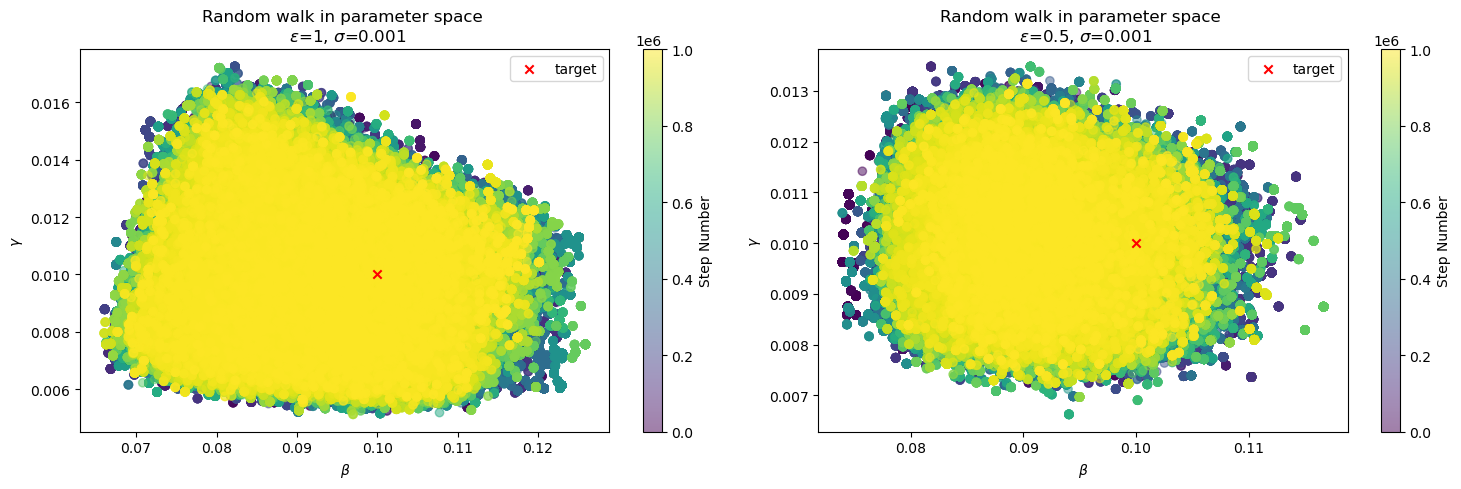

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

sc1 = ax[0].scatter(chain1[:, 0], chain1[:, 1], c=np.arange(chain5.shape[0]), cmap="viridis", alpha=0.5)
ax[0].set_xlabel(r'$\beta$')
ax[0].set_ylabel(r'$\gamma$')
ax[0].set_title("Random walk in parameter space \n $\epsilon$=1, $\sigma$=0.001")

# Draw an x at target point (0.1,0.01)
ax[0].scatter(0.1, 0.01, marker='x', color='red',label="target")

# add legend
ax[0].legend()

# Add colorbar with correct palette
cbar1 = fig.colorbar(sc1, ax=ax[0])

# Set label for colorbar
cbar1.set_label('Step Number')

sc2 = ax[1].scatter(chain3[:, 0], chain3[:, 1], c=np.arange(chain3.shape[0]), cmap='viridis', alpha=0.5)
ax[1].set_xlabel(r'$\beta$')
ax[1].set_ylabel(r'$\gamma$')
ax[1].set_title("Random walk in parameter space \n $\epsilon$=0.5, $\sigma$=0.001")

# Draw an x at target point (0.1,0.01)
ax[1].scatter(0.1, 0.01, marker='x', color='red',label="target")

# add legend
ax[1].legend()

# Add colorbar with correct palette
cbar2 = fig.colorbar(sc2, ax=ax[1])

# Set label for colorbar
cbar2.set_label('Step Number')

plt.tight_layout()

### Burn-in and autocorrelation

/tmp/ipykernel_1468/469291115.py:32: MatplotlibDeprecationWarning: The join function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax[0, 0].get_shared_y_axes().join(ax[0, 0], ax[0, 1])
/tmp/ipykernel_1468/469291115.py:33: MatplotlibDeprecationWarning: The join function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax[1, 0].get_shared_y_axes().join(ax[1, 0], ax[1, 1])


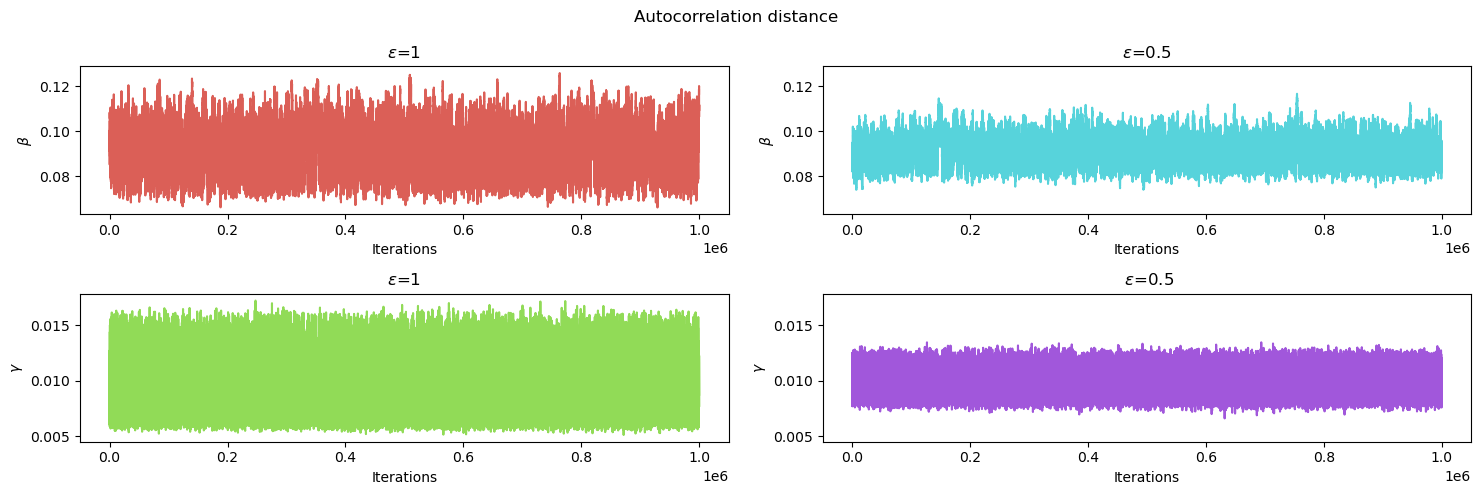

In [22]:
# Plotting the results
fig, ax = plt.subplots(2, 2, figsize=(15, 5))

colors = sns.color_palette("hls", 4)
# Plotting the chains
ax[0, 0].plot(chain1[:,0], color=colors[0],label = "beta")
ax[1, 0].plot(chain1[:,1], color=colors[1],label = "gamma")

ax[0, 1].plot(chain3[:,0], color=colors[2],label = "beta")
ax[1, 1].plot(chain3[:,1], color=colors[3],label = "gamma")


# Adding titles
ax[0, 0].set_title(r"$\epsilon$=1")
ax[1, 0].set_title(r"$\epsilon$=1")
ax[0, 1].set_title(r"$\epsilon$=0.5")
ax[1, 1].set_title(r" $\epsilon$=0.5")

# Adding labels to axes
ax[0, 0].set_xlabel("Iterations")
ax[1, 0].set_xlabel("Iterations")
ax[0, 1].set_xlabel("Iterations")
ax[1, 1].set_xlabel("Iterations")

# y axes
ax[0, 0].set_ylabel(r"$\beta$")
ax[1, 0].set_ylabel(r"$\gamma$")
ax[0, 1].set_ylabel(r"$\beta$")
ax[1, 1].set_ylabel(r"$\gamma$")

# Share y axes
ax[0, 0].get_shared_y_axes().join(ax[0, 0], ax[0, 1])
ax[1, 0].get_shared_y_axes().join(ax[1, 0], ax[1, 1])

# Set title to whole figure
fig.suptitle("Autocorrelation distance")

# Tight layout
plt.tight_layout()

All chains converge almost immediately. We see that the chain relative to $\epsilon$ = 0.5 has a bit less variance with respect to $\epsilon$ = 1.

A value of `burn-in` = 100 is chosen.

In [23]:
burn_in = 100 # 100 seems a reasonable burn-in period, seeing the plots

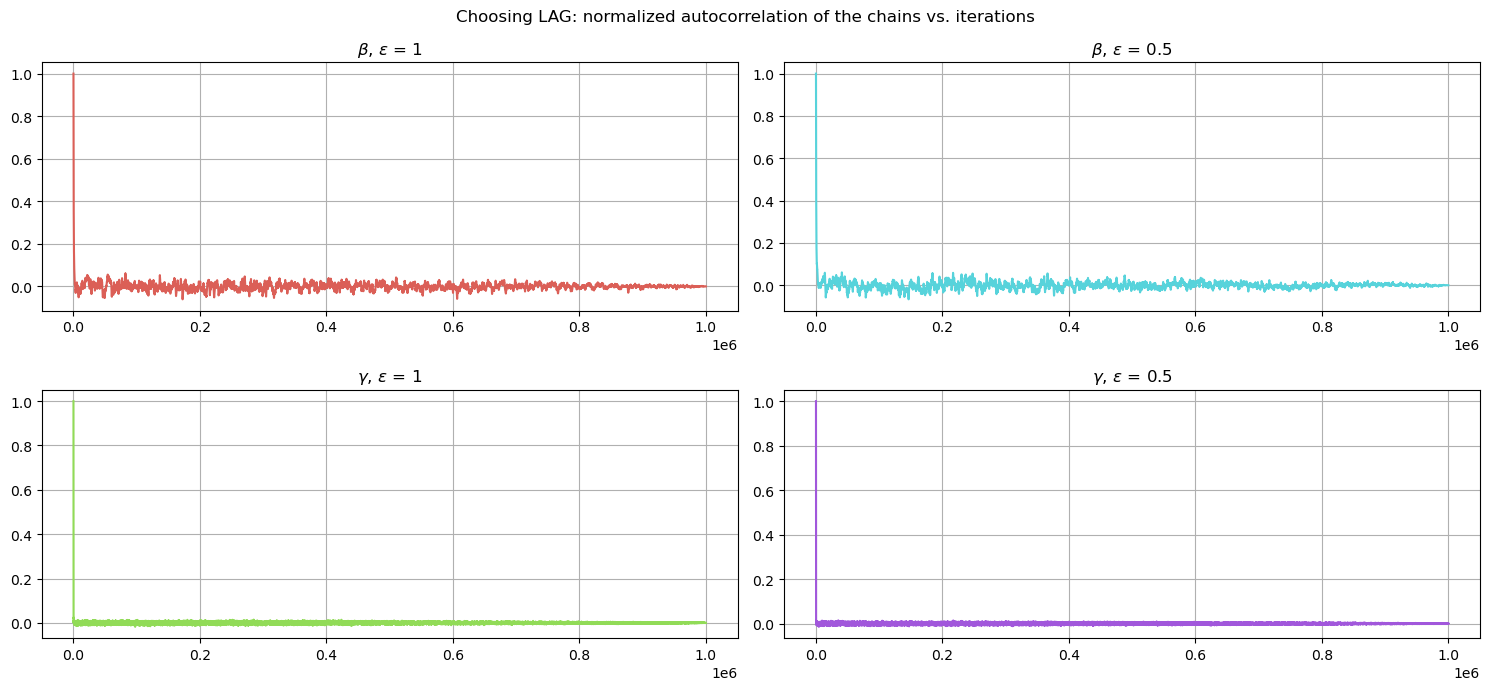

In [24]:
fig,ax = plt.subplots(2,2,figsize=(15,7))

colors = sns.color_palette("hls", 4)


ax[0,0].plot(correlate(chain1[burn_in:,0])/max(correlate(chain1[burn_in:,0])),color=colors[0],alpha=1)
ax[0,0].set_title(r'$\beta$, $\epsilon$ = 1')
ax[0,0].grid()

ax[1,0].plot(correlate(chain1[burn_in:,1])/max(correlate(chain1[burn_in:,1])),color=colors[1],alpha=1)
ax[1,0].set_title(r'$\gamma$, $\epsilon$ = 1')
ax[1,0].grid()


ax[0,1].plot(correlate(chain3[burn_in:,0])/max(correlate(chain3[burn_in:,0])),color=colors[2],alpha=1)
ax[0,1].set_title(r'$\beta$, $\epsilon$ = 0.5')
ax[0,1].grid()

ax[1,1].plot(correlate(chain3[burn_in:,1])/max(correlate(chain3[burn_in:,1])),color=colors[3],alpha=1)
ax[1,1].set_title(r'$\gamma$, $\epsilon$ = 0.5')
ax[1,1].grid()

# Set title to whole figure
fig.suptitle("Choosing LAG: normalized autocorrelation of the chains vs. iterations")

plt.tight_layout()

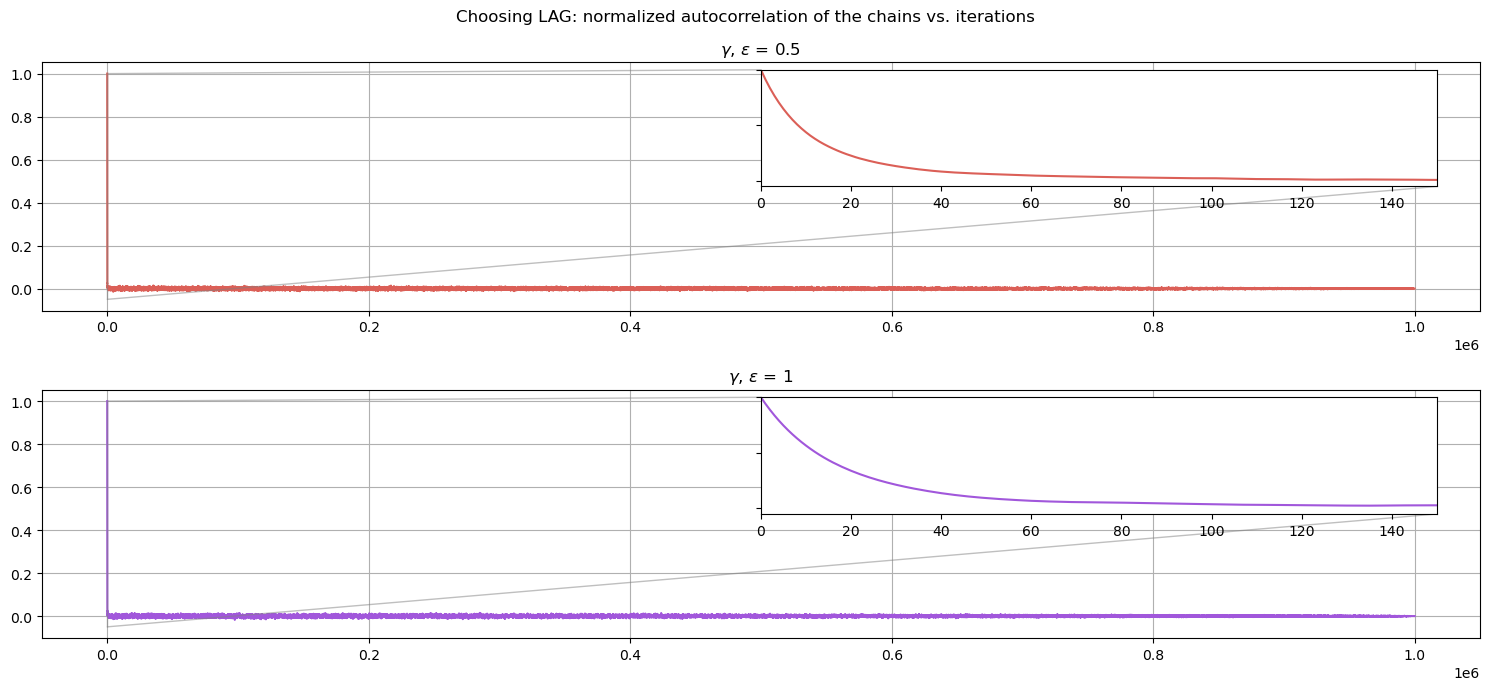

In [25]:
fig, ax = plt.subplots(2,figsize=(15,7))


ax[0].plot(correlate(chain3[burn_in:,1])/max(correlate(chain3[burn_in:,1])),color=colors[0],alpha=1)


# inset axes....
x1, x2, y1, y2 = 0, 150, -.05, 1  # subregion of the original image

axins = ax[0].inset_axes(
    [0.5, 0.5, 0.47, 0.47],
    xlim=(x1, x2), ylim=(y1, y2), xticklabels=[], yticklabels=[])

ax[0].indicate_inset_zoom(axins)

axins.plot(correlate(chain3[burn_in:,1])/max(correlate(chain3[burn_in:,1])),color=colors[0],alpha=1)

# add xticks with numbers to the inset axes
axins.set_xticks(np.arange(x1,x2,20), labels=np.arange(x1,x2,20))

ax[0].set_title(r"$\gamma$, $\epsilon$ = 0.5")

axins2 = ax[1].inset_axes(
    [0.5, 0.5, 0.47, 0.47],
    xlim=(x1, x2), ylim=(y1, y2), xticklabels=[], yticklabels=[])

ax[1].plot(correlate(chain1[burn_in:,1])/max(correlate(chain1[burn_in:,1])),color=colors[3],alpha=1)
ax[1].set_title(r"$\gamma$, $\epsilon$ = 1")
ax[1].indicate_inset_zoom(axins2)
axins2.set_xticks(np.arange(x1,x2,20), labels=np.arange(x1,x2,20))
axins2.plot(correlate(chain1[burn_in:,1])/max(correlate(chain1[burn_in:,1])),color=colors[3],alpha=1)

# add grids
ax[0].grid()
ax[1].grid()

fig.suptitle("Choosing LAG: normalized autocorrelation of the chains vs. iterations")

plt.tight_layout()

We choose  `lag = 100` and `burn-in = 100`

In [26]:
lag = 100
chain1[burn_in::lag,1].shape

(10000,)

## Posteriors

/tmp/ipykernel_1468/1879631214.py:71: MatplotlibDeprecationWarning: The join function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax[0, 0].get_shared_y_axes().join(ax[0, 0], ax[0, 1])


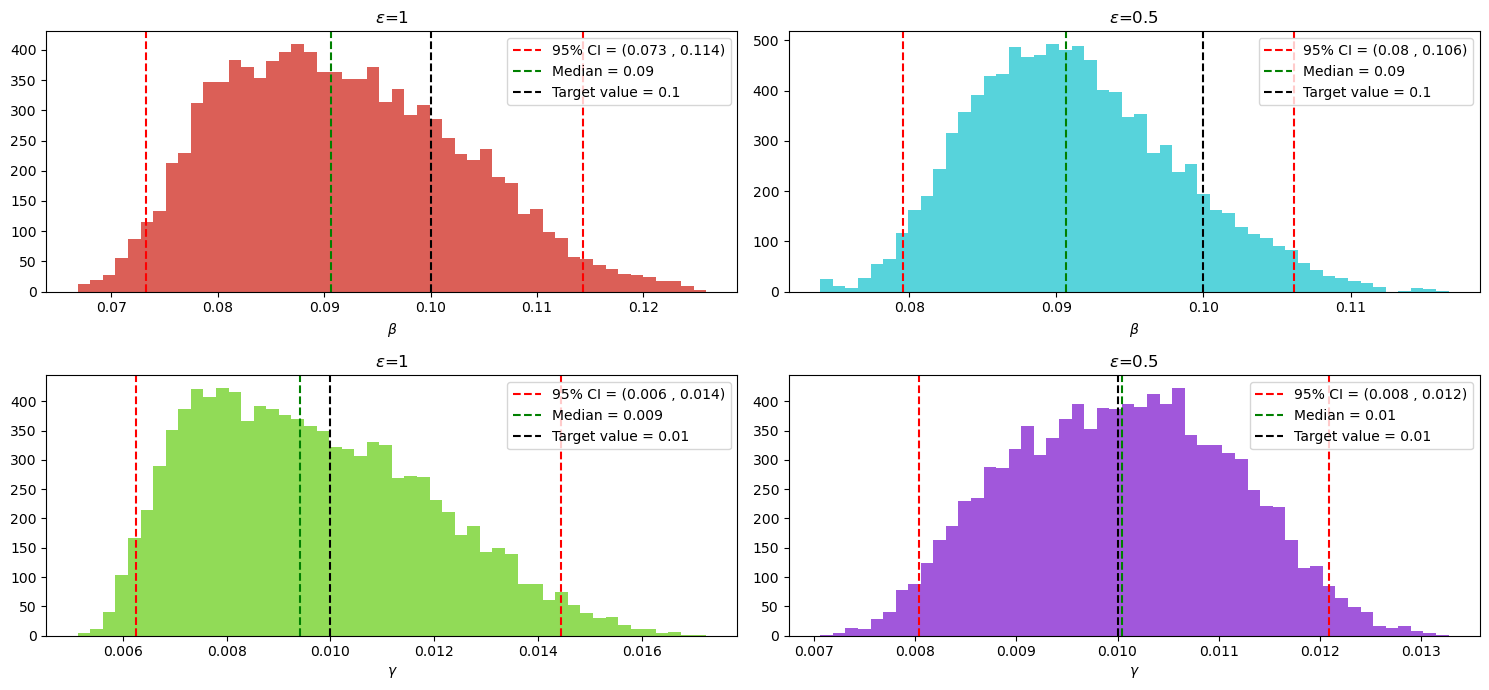

In [27]:
# Histograms of the chains
fig, ax = plt.subplots(2, 2, figsize=(15, 7))

colors = sns.color_palette("hls", 4)

bins = 50

# Plotting the chains
ax[0, 0].hist(chain1[burn_in::lag,0], color=colors[0], bins=bins)
ax[1, 0].hist(chain1[burn_in::lag,1], color=colors[1], bins=bins)
ax[0, 1].hist(chain3[burn_in::lag,0], color=colors[2], bins=bins)
ax[1, 1].hist(chain3[burn_in::lag,1], color=colors[3], bins=bins)

# Adding 95% Credibility intervals and median

ax[0, 0].axvline(np.percentile(chain1[burn_in::lag,0], 2.5), color="red", linestyle="--", 
                 label=f"95% CI = ({round(np.percentile(chain1[burn_in::lag,0], 2.5),3)} , {round(np.percentile(chain1[burn_in::lag,0], 97.5),3)})")
ax[0, 0].axvline(np.percentile(chain1[burn_in::lag,0], 97.5), color="red", linestyle="--")

ax[1, 0].axvline(np.percentile(chain1[burn_in::lag,1], 2.5), color="red", linestyle="--", 
                 label=f"95% CI = ({round(np.percentile(chain1[burn_in::lag,1], 2.5),3)} , {round(np.percentile(chain1[burn_in::lag,1], 97.5),3)})")
ax[1, 0].axvline(np.percentile(chain1[burn_in::lag,1], 97.5), color="red", linestyle="--")

ax[0, 0].axvline(np.median(chain1[burn_in::lag,0]), color="green", linestyle="--", label=f"Median = {round(np.median(chain1[burn_in::lag,0]),2)}")
ax[1, 0].axvline(np.median(chain1[burn_in::lag,1]), color="green", linestyle="--", label=f"Median = {round(np.median(chain1[burn_in::lag,1]),3)}")

ax[0, 1].axvline(np.percentile(chain3[burn_in::lag,0], 2.5), color="red", linestyle="--", 
                 label=f"95% CI = ({round(np.percentile(chain3[burn_in::lag,0], 2.5),3)} , {round(np.percentile(chain3[burn_in::lag,0], 97.5),3)})")
ax[0, 1].axvline(np.percentile(chain3[burn_in::lag,0], 97.5), color="red", linestyle="--")

ax[1, 1].axvline(np.percentile(chain3[burn_in::lag,1], 2.5), color="red", linestyle="--", 
                 label=f"95% CI = ({round(np.percentile(chain3[burn_in::lag,1], 2.5),3)} , {round(np.percentile(chain3[burn_in::lag,1], 97.5),3)})")
ax[1, 1].axvline(np.percentile(chain3[burn_in::lag,1], 97.5), color="red", linestyle="--")

ax[0, 1].axvline(np.median(chain3[burn_in::lag,0]), color="green", linestyle="--", 
                 label=f"Median = {round(np.median(chain3[burn_in::lag,0]),2)}")
ax[1, 1].axvline(np.median(chain3[burn_in::lag,1]), color="green", linestyle="--",
                 label=f"Median = {round(np.median(chain3[burn_in::lag,1]),3)}")



# Adding titles
ax[0, 0].set_title(r"$\epsilon$=1")
ax[1, 0].set_title(r"$\epsilon$=1")
ax[0, 1].set_title(r"$\epsilon$=0.5")
ax[1, 1].set_title(r"$\epsilon$=0.5")


# Add vertical lines for the true values
# true values are beta=0.1 and gamma=0.01
ax[0, 0].axvline(0.1, color="black", linestyle="--",label="Target value = 0.1")
ax[1, 0].axvline(0.01, color="black", linestyle="--",label="Target value = 0.01")
ax[0, 1].axvline(0.1, color="black", linestyle="--", label="Target value = 0.1")
ax[1, 1].axvline(0.01, color="black", linestyle="--", label="Target value = 0.01")


# Adding legend
ax[0, 0].legend()
ax[1, 0].legend()
ax[0, 1].legend()
ax[1, 1].legend()


# Set x and y labels
ax[0, 0].set_xlabel(r"$\beta$")
ax[1, 0].set_xlabel(r"$\gamma$")
ax[0, 1].set_xlabel(r"$\beta$")
ax[1, 1].set_xlabel(r"$\gamma$")

# Share y axes
ax[0, 0].get_shared_y_axes().join(ax[0, 0], ax[0, 1])


# Tight layout
plt.tight_layout()




We see that there is not a big difference between different $\epsilon$ in the estimation of the parameters.

## Metropolis-Hastings MCMC
To compare the performance of ABC and ABC-MCMC algorithms, we implemented a classical Metropolis(-Hastings) Monte Carlo Markov chain scheme. This is possible since, in this case, we can actually compute the true posterior distribution. Moreover our parameter space is a low dimensional one, therefore we should not encounter issues with low acceptance rates.

The posterior is:

\begin{equation*}

π(β , γ |S_0 , I_0 , R_0 , \Delta \textbf{I}, \Delta \textbf{R}) \propto \pi( \beta) \times \pi( \gamma) \times \prod_{t=1}^{T} \mathcal{P} \left(\Delta I_t | S_{t-1}, I_{t-1}, \beta \right) \times \prod_{t=1}^{T} \mathcal{P} \left(\Delta R_t | I_{t-1}, \gamma \right)

\end{equation*}

where $\pi(.)$ are the priors on the parameters, and $\mathcal{P}(.)$ are the binomial likelihood functions that evolve the model through the stochastic terms $\Delta \textbf{I}, \Delta \textbf{R}$.

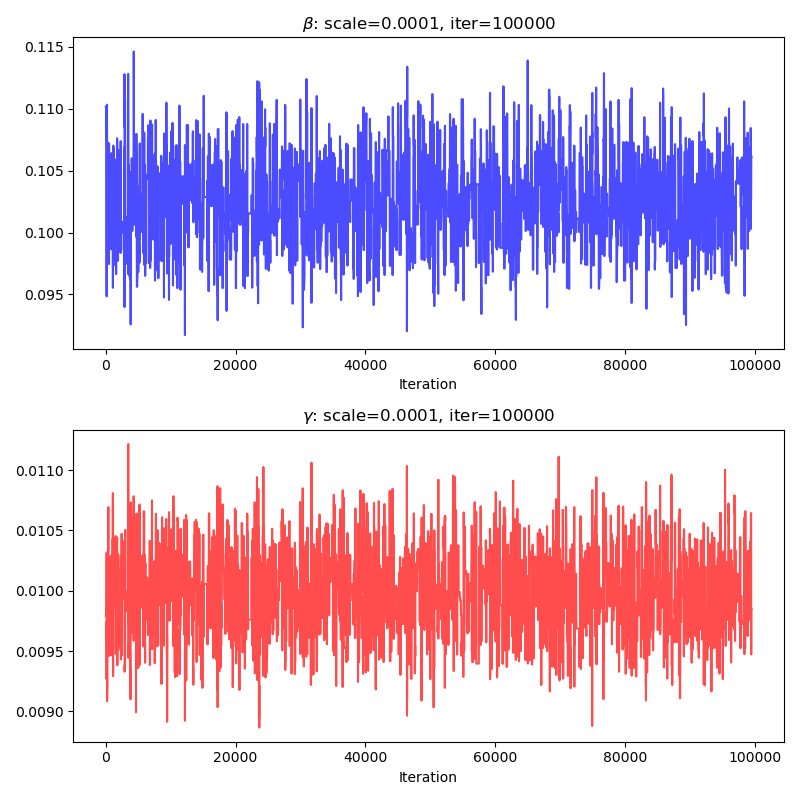

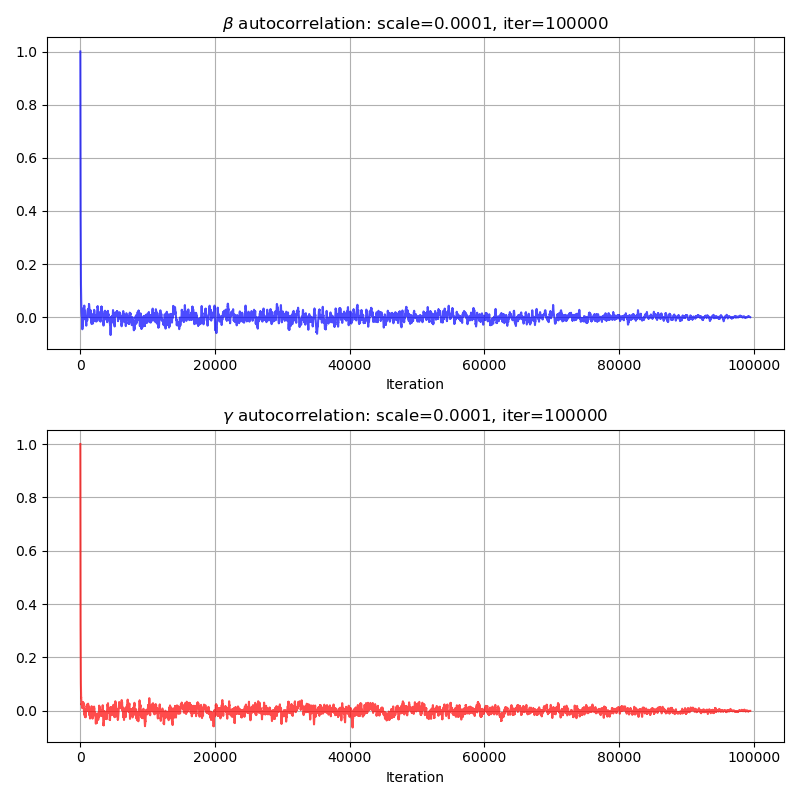

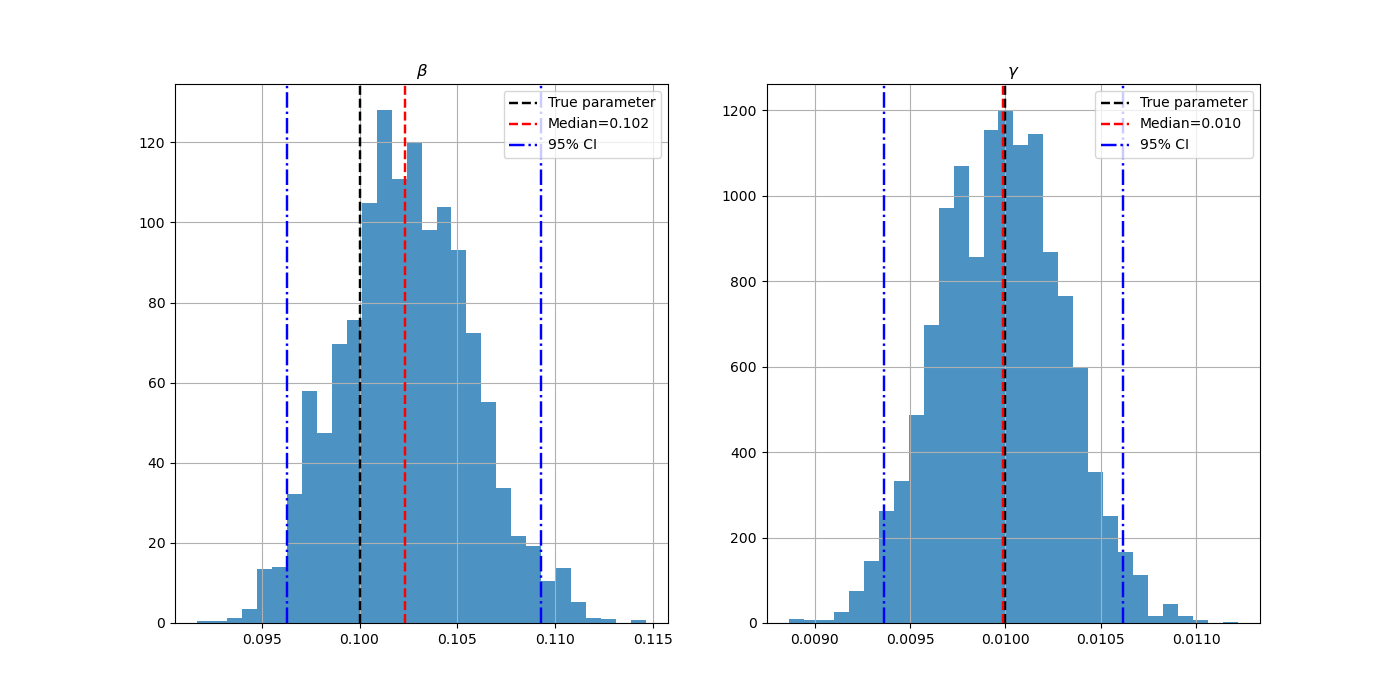

In [ ]:
i14 = Image.open('./results/chain_euclid_norm=0.0001_Niter=100000.0.png')
i15 = Image.open('./results/auto_chain_norm=0.0001_Niter=1000000.png')
i16 = Image.open('./results/hist_chain_norm=0.0001_Niter=1000000.png')
display(i14, i15, i16)

The chains are plotted with a burn-in of 500, and the histograms with a lag of 10.

As expected, the Metropolis MCMC performs better than the ABC algorithm, since it targets the true distribution and make use of the model knowledge. The 95% credibility intervals are significantly smaller in this case, and sampling is faster.